In [1]:

!pip uninstall -y bitsandbytes -q
!pip install -U \
  "transformers>=4.45.0" \
  "accelerate>=0.33.0" \
  "bitsandbytes==0.47.0" \
  pillow -q


import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
!unrar x /content/drive/MyDrive/AmirHossein/images_clean_v2.rar /content/drive/MyDrive/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/AmirHossein/images_clean_v2.rar

Creating    /content/drive/MyDrive/images_clean_v2                    OK
Extracting  /content/drive/MyDrive/images_clean_v2/%28homeyra_riazi%29750854_02.jpg       0%  OK 
Extracting  /content/drive/MyDrive/images_clean_v2/%D5%8D%D5%A1%D5%B4%D5%B8%D6%82%D5%A7%D5%AC_%D4%BD%D5%A1%D5%B9%D5%AB%D5%AF%D5%A5%D5%A1%D5%B6.jpg       1%  OK 
Extracting  /content/drive/MyDrive/images_clean_v2/%D8%A2%D8%B1%D8%B4_%D9%85%DB%8C%D8%B1_%D8%A7%D8%AD%D9%85%D8%AF%DB%8C.jpg       1%  OK 
Extracting  /content/drive/MyDrive/images_clean_v2/%D8%A7%D8%A8%D9%88%D8%A7%D9%84%D8%AD%D8%B3%D9%86_%D8%AE%D9%88%D8%B4%D8%B1%D9%88.jpg       1%  OK 
Extracting  /content/drive/MyDrive/images_clean_v2/%D8%A7%D8%AD%D9%85%D8%AF_%D8%B2%D9%86%DA%AF%D9%86%D9%87.jpg       1%  OK 
Extracting  /content/drive/MyDrive/images_clean_v2/%D8%A7%D8%B3

In [2]:
!pip install -q faiss-cpu sentence-transformers open_clip_torch bitsandbytes accelerate transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
import os, io, json, re, math, gc, glob, random, ast
import numpy as np
import pandas as pd
from dataclasses import dataclass

@dataclass
class CFG:
    data_csv: str = "/content/drive/MyDrive/AmirHossein/final_merged_images.csv"
    image_roots: tuple = (
        "/content/drive/MyDrive/images_clean",
        "/content/drive/MyDrive/images_clean_v2",
    )
    id_col: str   = "id"
    img_col: str  = "image_paths"
    text_col: str = "bio"
    qjson_col: str = "questions_json"
    text_encoder_name: str = "sentence-transformers/clip-ViT-B-32-multilingual-v1"
    clip_image_model_name: str = "ViT-B-32"
    clip_ckpt: str = "laion2b_s34b_b79k"
    embed_dim: int = 512
    text_only_emb_path:   str = "/content/drive/MyDrive/AmirHossein/v1/text_doc_emb.npy"
    text_only_index_path: str = "/content/drive/MyDrive/AmirHossein/v1/faiss_text_only.ip"
    fusion_emb_path:      str = "/content/drive/MyDrive/AmirHossein/v1/fusion_doc_emb.npy"
    fusion_index_path:    str = "/content/drive/MyDrive/AmirHossein/v1/faiss_fusion.ip"
    top_k: int = 5
    alpha_doc: float = 0.7
    alpha_q: float   = 0.7

CFG = CFG()

def normalize_digits_months(s: str) -> str:
    if not isinstance(s, str):
        s = str(s)
    trans = str.maketrans("۰۱۲۳۴۵۶۷۸۹٠١٢٣٤٥٦٧٨٩", "01234567890123456789")
    s = s.translate(trans).replace("\u200c"," ").strip()
    months = {
        "فروردین":"01","اردیبهشت":"02","خرداد":"03","تیر":"04","مرداد":"05","شهریور":"06",
        "مهر":"07","آبان":"08","آذر":"09","دی":"10","بهمن":"11","اسفند":"12",
        "march":"03","april":"04","may":"05","june":"06","july":"07","august":"08",
        "september":"09","october":"10","november":"11","december":"12",
        "jan":"01","feb":"02","mar":"03","apr":"04","jun":"06","jul":"07","aug":"08","sep":"09","oct":"10","nov":"11","dec":"12",
    }
    for k,v in months.items():
        s = s.replace(k, v).replace(k.capitalize(), v)
    return s

def l2_normalize_np(x: np.ndarray, eps=1e-12) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True) + eps
    return (x / n).astype("float32")

def _parse_images_field(val):
    if isinstance(val, list):
        return [str(x).strip() for x in val if str(x).strip()]
    if pd.isna(val):
        return []
    s = str(val).strip()
    if not s:
        return []
    try:
        parsed = ast.literal_eval(s)
        if isinstance(parsed, list):
            return [str(x).strip() for x in parsed if str(x).strip()]
    except Exception:
        pass
    if " | " in s:
        return [p.strip() for p in s.split("|") if p.strip()]
    return [s]

def _norm_like_colab(p: str) -> str:
    if not isinstance(p, str) or not p.strip():
        return ""
    p = p.strip().replace("\\", "/").lstrip("./")
    return p

def _basename(p: str) -> str:
    return os.path.basename(_norm_like_colab(p))

def _exists_any(path: str) -> bool:
    return os.path.isfile(path)

def resolve_one_path(rel_or_abs: str) -> str:
    s = _norm_like_colab(rel_or_abs)
    if not s:
        return ""
    if os.path.isabs(s) and _exists_any(s):
        return os.path.normpath(s)
    last_candidate = s
    for root in CFG.image_roots:
        candidate = os.path.normpath(os.path.join(root, s))
        last_candidate = candidate
        if _exists_any(candidate):
            return candidate
    base = _basename(s)
    for root in CFG.image_roots:
        candidate = os.path.normpath(os.path.join(root, base))
        last_candidate = candidate
        if _exists_any(candidate):
            return candidate
    for root in CFG.image_roots:
        hits = glob.glob(os.path.join(root, "**", base), recursive=True)
        if hits:
            return os.path.normpath(hits[0])
    return os.path.normpath(last_candidate)

def resolve_many(paths):
    seen = set()
    out = []
    for p in paths or []:
        q = resolve_one_path(p)
        if q and q not in seen:
            seen.add(q)
            out.append(q)
    return out

df = pd.read_csv(CFG.data_csv, encoding="utf-8-sig")
if CFG.img_col not in df.columns:
    raise KeyError(f"Expected column '{CFG.img_col}' in {CFG.data_csv}")
df["image_paths_list"] = df[CFG.img_col].apply(_parse_images_field)
df["image_paths_abs"]  = df["image_paths_list"].apply(resolve_many)
print("Rows:", len(df))
print(df[[CFG.id_col, "image_paths_abs"]].head(2))
n_missing_any = (df["image_paths_abs"].apply(lambda lst: len(lst) == 0)).sum()
print(f"[INFO] rows with no resolvable images: {n_missing_any}")


In [ ]:
df = df[df["image_paths_abs"].apply(lambda lst: len(lst) > 0)].reset_index(drop=True)

In [ ]:
df.columns

##Fine Tuning Please Dont run this cells and Jump into Evaluate Cell


In [ ]:
df['image_paths'][0]

"['images_clean\\\\Kamshad-Kooshan1.png', 'images_clean_v2\\\\Kamshad-Kooshan1.jpg']"

In [ ]:
CFG.text_col

'bio'

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import open_clip
from sentence_transformers import SentenceTransformer
import faiss
import os

BATCH_SIZE      = 64
EPOCHS          = 5
LR              = 5e-6
UNFREEZE_IMAGE  = False
NUM_WORKERS     = 4
AUGMENT_IMAGES  = True
SAVE_CKPT_PATH  = "/content/drive/MyDrive/AmirHossein/v1/finetune_clip_fa.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

TEXT_COL = "bio" if "bio" in df.columns else CFG.text_col
if TEXT_COL not in df.columns:
    df[TEXT_COL] = ""

df["image_paths_abs"] = df["image_paths_abs"].apply(lambda x: x if isinstance(x, list) else [])
df = df[df["image_paths_abs"].apply(len) > 0].reset_index(drop=True)
print("Rows with ≥1 image:", len(df))

class MultiImageContrastiveDataset(Dataset):
    def __init__(self, dataframe, preprocess, augment=False):
        self.preprocess = preprocess
        self.augment = augment
        self.items = []
        for _, row in dataframe.iterrows():
            text = normalize_digits_months(str(row[TEXT_COL]))
            for p in row["image_paths_abs"]:
                self.items.append((p, text))
        self.aug = transforms.RandomApply([
            transforms.RandomResizedCrop(224, scale=(0.9, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(p=0.5),
        ], p=0.4)
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        img_path, text = self.items[idx]
        img = Image.open(img_path).convert("RGB")
        if self.augment:
            img = self.aug(img)
        img = self.preprocess(img)
        return img, text

clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    model_name=CFG.clip_image_model_name,
    pretrained=CFG.clip_ckpt
)
clip_model = clip_model.to(device).eval()

mclip = SentenceTransformer(CFG.text_encoder_name).to(device)
mclip.train()

IMG_DIM = CFG.embed_dim
TXT_DIM = CFG.embed_dim
proj_img = nn.Identity().to(device)
proj_txt = nn.Linear(TXT_DIM, TXT_DIM, bias=False).to(device)
nn.init.eye_(proj_txt.weight)

logit_scale = nn.Parameter(torch.ones([]) * torch.log(torch.tensor(1/0.07))).to(device)

def clip_contrastive_loss(image_feats, text_feats, logit_scale):
    image_feats = image_feats / image_feats.norm(dim=-1, keepdim=True)
    text_feats  = text_feats  / text_feats.norm(dim=-1, keepdim=True)
    logits_per_image = logit_scale.exp() * image_feats @ text_feats.t()
    logits_per_text  = logits_per_image.t()
    targets = torch.arange(image_feats.size(0), device=image_feats.device)
    loss_i = nn.functional.cross_entropy(logits_per_image, targets)
    loss_t = nn.functional.cross_entropy(logits_per_text, target


Device: cuda
Rows with ≥1 image: 2351


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Train pairs: 2928 | Val pairs: 341


## Fine tuning models V2

In [ ]:
class Trainables(nn.Module):
    def __init__(self, embed_dim, unfreeze_image):
        super().__init__()
        self.proj_img = nn.Identity()
        self.proj_txt = nn.Linear(embed_dim, embed_dim, bias=False)
        nn.init.eye_(self.proj_txt.weight)
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07), dtype=torch.float32))

    def forward(self):
        return self.proj_img, self.proj_txt, self.logit_scale


trainables = Trainables(CFG.embed_dim, UNFREEZE_IMAGE).to(device)
proj_img = trainables.proj_img
proj_txt = trainables.proj_txt
logit_scale = trainables.logit_scale


params = list(filter(lambda p: p.requires_grad,
                     list(mclip.parameters())
                     + list(proj_txt.parameters())
                     + ([] if isinstance(proj_img, nn.Identity) else list(proj_img.parameters()))
                     + [logit_scale]))
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=0.01)


In [ ]:
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

best_val = float("inf")

for epoch in range(1, EPOCHS+1):
    if UNFREEZE_IMAGE:
        clip_model.train()
    else:
        clip_model.eval()
    mclip.train(); proj_txt.train(); proj_img.train()

    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}")
    running = 0.0
    for images, texts in pbar:
        images = images.to(device, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            img_feats = proj_img(forward_image(images))
            txt_feats = proj_txt(encode_text_batch(list(texts)))
            loss, _ = clip_contrastive_loss(img_feats, txt_feats, logit_scale)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        running += loss.item()
        pbar.set_postfix(loss=f"{running/(pbar.n or 1):.4f}")

    if val_dl is not None:
        val_loss = evaluate(val_dl)
        print(f"[VAL] epoch {epoch}: loss={val_loss:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save({
                "mclip": mclip.state_dict(),
                "proj_txt": proj_txt.state_dict(),
                "proj_img": proj_img.state_dict(),
                "logit_scale": logit_scale.detach().cpu(),
                "cfg": CFG.__dict__,
                "epoch": epoch,
                "val_loss": val_loss,
                "unfreeze_image": UNFREEZE_IMAGE,
                "clip_ckpt": CFG.clip_ckpt,
                "clip_image_model_name": CFG.clip_image_model_name,
                "text_encoder_name": CFG.text_encoder_name,
                "text_col_used": TEXT_COL,
            }, SAVE_CKPT_PATH)
            print(f"[CKPT] saved -> {SAVE_CKPT_PATH}")
    else:
        torch.save({
            "mclip": mclip.state_dict(),
            "proj_txt": proj_txt.state_dict(),
            "proj_img": proj_img.state_dict(),
            "logit_scale": logit_scale.detach().cpu(),
            "cfg": CFG.__dict__,
            "epoch": epoch,
            "unfreeze_image": UNFREEZE_IMAGE,
            "clip_ckpt": CFG.clip_ckpt,
            "clip_image_model_name": CFG.clip_image_model_name,
            "text_encoder_name": CFG.text_encoder_name,
            "text_col_used": TEXT_COL,
        }, SAVE_CKPT_PATH)
        print(f"[CKPT] saved -> {SAVE_CKPT_PATH}")

/tmp/ipython-input-4223587989.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
Epoch 1/5:   0%|          | 0/45 [00:00<?, ?it/s]/tmp/ipython-input-4223587989.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):
Epoch 1/5:  69%|██████▉   | 31/45 [07:25<02:34, 11.03s/it, loss=4.3659]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validate: 100%|██████████| 6/6 [01:41<00:00, 16.94s/it]


[VAL] epoch 1: loss=4.0032
[CKPT] saved -> /content/drive/MyDrive/AmirHossein/v1/finetune_clip_fa.pt


Epoch 2/5:  62%|██████▏   | 28/45 [00:15<00:05,  2.90it/s, loss=4.3724]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validate: 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


[VAL] epoch 2: loss=3.9933
[CKPT] saved -> /content/drive/MyDrive/AmirHossein/v1/finetune_clip_fa.pt


Epoch 3/5:  13%|█▎        | 6/45 [00:03<00:15,  2.57it/s, loss=5.0488]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validate: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


[VAL] epoch 3: loss=3.9839
[CKPT] saved -> /content/drive/MyDrive/AmirHossein/v1/finetune_clip_fa.pt


Epoch 4/5:  36%|███▌      | 16/45 [00:05<00:05,  5.51it/s, loss=4.8004]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validate: 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]


[VAL] epoch 4: loss=3.9747
[CKPT] saved -> /content/drive/MyDrive/AmirHossein/v1/finetune_clip_fa.pt


Epoch 5/5:  60%|██████    | 27/45 [00:08<00:04,  4.25it/s, loss=4.5172]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validate: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


[VAL] epoch 5: loss=3.9659
[CKPT] saved -> /content/drive/MyDrive/AmirHossein/v1/finetune_clip_fa.pt


In [ ]:
!pip install -q faiss-cpu sentence-transformers open_clip_torch bitsandbytes accelerate transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
import math, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import os, numpy as np

FTI_DIR = os.path.join(getattr(CFG, "ft_dir", "/content/drive/MyDrive/AmirHossein/v1"), "text_image_ft")
os.makedirs(FTI_DIR, exist_ok=True)
best_path = os.path.join(FTI_DIR, "ti_heads_best.pt")
last_path = os.path.join(FTI_DIR, "ti_heads_last.pt")
print("[PATH] FTI_DIR =", FTI_DIR)

with torch.no_grad():
    t_list = [normalize_digits_months(str(x)) for x in df[TEXT_COL].tolist()]
    t_arr  = mclip.encode(t_list, convert_to_numpy=True, normalize_embeddings=False).astype("float32")

class HeadOnlyDataset(Dataset):
    def __init__(self, dataframe, t_arr, preprocess, augment=False):
        self.preprocess = preprocess
        self.augment = augment
        self.items = []
        for ridx, row in dataframe.reset_index(drop=True).iterrows():
            for p in row["image_paths_abs"]:
                self.items.append((p, ridx))
        self.t_arr = t_arr
        self.aug = transforms.RandomApply([
            transforms.RandomResizedCrop(224, scale=(0.9, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(p=0.5),
        ], p=0.4)
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        p, ridx = self.items[i]
        img = Image.open(p).convert("RGB")
        if self.augment: img = self.aug(img)
        img = clip_preprocess(img)
        t_emb = torch.from_numpy(self.t_arr[ridx])
        return t_emb, img

class TIHeads(nn.Module):
    def __init__(self, d=CFG.embed_dim):
        super().__init__()
        self.txt = nn.Linear(d, d, bias=False)
        nn.init.eye_(self.txt.weight)
        self.img = nn.Identity()
        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07), dtype=torch.float32))
    def forward(self, t_emb, i_emb):
        t = nn.functional.normalize(self.txt(t_emb), dim=-1)
        i = nn.functional.normalize(self.img(i_emb), dim=-1)
        return torch.exp(self.logit_scale) * (i @ t.t())

BATCH_SIZE, NUM_WORKERS = 64, 4
ds_tr = HeadOnlyDataset(df_train, t_arr, clip_preprocess, augment=True)
ds_va = HeadOnlyDataset(df_val,   t_arr, clip_preprocess, augment=False) if df_val is not None else None
dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, drop_last=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=False) if ds_va else None

heads = TIHeads(CFG.embed_dim).to(device)
OPT = torch.optim.AdamW(heads.parameters(), lr=5e-5, weight_decay=0.01)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

def run_epoch(loader, train=True):
    heads.train(mode=train)
    tot, n = 0.0, 0
    for t_emb, pixel in tqdm(loader, disable=False):
        t_emb = t_emb.to(device, non_blocking=True)
        pixel = pixel.to(device, non_blocking=True)

        with torch.no_grad():
            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=(device=='cuda')):
                i_emb = clip_model.encode_image(pixel)
                i_emb = nn.functional.normalize(i_emb, dim=-1)

        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=(device=='cuda')):
            logits = heads(t_emb, i_emb)
            tgt = torch.arange(logits.size(0), device=logits.device)
            loss = 0.5*(nn.functional.cross_entropy(logits, tgt) +
                        nn.functional.cross_entropy(logits.t(), tgt))

        if train:
            OPT.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(OPT)
            scaler.update()

        bs = logits.size(0)
        tot += loss.item() * bs
        n   += bs
    return tot / max(1, n)

EPOCHS, best_score = 2, -float('inf')
print("[TRAIN] Head-Only...")
for ep in range(1, EPOCHS+1):
    tr = run_epoch(dl_tr, train=True)
    va = run_epoch(dl_va, train=False) if dl_va else tr
    score = -va
    print(f"[EP {ep}] train_loss={tr:.4f}  valid_loss={va:.4f}")
    if score > best_score:
        best_score = score
        torch.save({"state_dict": heads.state_dict(), "embed_dim": CFG.embed_dim}, best_path)
        print("[CKPT] saved BEST →", best_path)

if not os.path.isfile(best_path):
    torch.save({"state_dict": heads.state_dict(), "embed_dim": CFG.embed_dim}, last_path)
    import shutil; shutil.copy(last_path, best_path)
    print("[CKPT] forced save →", last_path, "and copied to →", best_path)

ckpt = torch.load(best_path, map_location="cpu")
heads.load_state_dict(ckpt["state_dict"]); heads.eval().to(device)
print("[OK] loaded heads from:", best_path)


[PATH] FTI_DIR = /content/drive/MyDrive/AmirHossein/v1/text_image_ft


/tmp/ipython-input-2455834093.py:67: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


[TRAIN] Head-Only...


 58%|█████▊    | 26/45 [00:06<00:05,  3.55it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 6/6 [00:01<00:00,  3.01it/s]


[EP 1] train_loss=4.2103  valid_loss=4.1271
[CKPT] saved BEST → /content/drive/MyDrive/AmirHossein/v1/text_image_ft/ti_heads_best.pt


  0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

[EP 2] train_loss=4.1809  valid_loss=4.1195
[CKPT] saved BEST → /content/drive/MyDrive/AmirHossein/v1/text_image_ft/ti_heads_best.pt
[OK] loaded heads from: /content/drive/MyDrive/AmirHossein/v1/text_image_ft/ti_heads_best.pt


In [ ]:
df

,id,bio,image_paths,image_paths_list,image_paths_abs
0,کامشاد کوشان,کامشاد کوشان، متولد ۲۸ شهریور ۱۳۴۱ در تهران، د...,"['images_clean\\Kamshad-Kooshan1.png', 'images...","[images_clean\Kamshad-Kooshan1.png, images_cle...",[/content/drive/MyDrive/images_clean/images_cl...
1,ایران دفتری,ایران دفتری، بازیگر سینما و تئاتر، در سال ۱۲۸۶...,"['images_clean\\Iran_Daftari.png', 'images_cle...","[images_clean\Iran_Daftari.png, images_clean_v...",[/content/drive/MyDrive/images_clean/images_cl...
2,فتح‌الله منوچهری,فتح‌الله منوچهری که با نام فرود فولادوند نیز ش...,['images_clean\\%D9%81%D8%B1%D9%88%D8%AF_%D9%8...,[images_clean\%D9%81%D8%B1%D9%88%D8%AF_%D9%81%...,[/content/drive/MyDrive/images_clean/images_cl...
3,چکامه چمن‌ماه,چکامه چمن‌ماه، در ۲۳ مرداد ۱۳۵۹ در شیراز، استا...,['images_clean\\220px-Chakameh_Chaman_Mah_2015...,[images_clean\220px-Chakameh_Chaman_Mah_201502...,[/content/drive/MyDrive/images_clean/images_cl...
4,عباس غزالی,عباس غزالی، در چهاردهم بهمن ۱۳۶۳ در تهران متول...,['images_clean\\250px-Abbas_Ghazali_at_34th_Fa...,[images_clean\250px-Abbas_Ghazali_at_34th_Fajr...,[/content/drive/MyDrive/images_clean/images_cl...
...,...,...,...,...,...
2346,عطار,عطار، با نام کامل فریدالدین ابوحامد محمد عطار ...,['images_clean_v2\\330px-%D8%AA%D9%86%D8%AF%DB...,[images_clean_v2\330px-%D8%AA%D9%86%D8%AF%DB%8...,[/content/drive/MyDrive/images_clean_v2/330px-...
2347,نظامی گنجوی,نظامی گنجوی، که با نام‌های «نظامی»، «حکیم نظام...,['images_clean_v2\\250px-Nizami_Rug_Crop.jpg'],[images_clean_v2\250px-Nizami_Rug_Crop.jpg],[/content/drive/MyDrive/images_clean_v2/250px-...
2348,سعدی,سعدی، با نام کامل ابومحمد مشرف‌الدین مصلح بن ع...,['images_clean_v2\\250px-Sadi_in_a_Rose_garden...,[images_clean_v2\250px-Sadi_in_a_Rose_garden.jpg],[/content/drive/MyDrive/images_clean_v2/250px-...
2349,جامی,جامی، ملقب به نورالدین عبد الرحمن بن احمد بن م...,['images_clean_v2\\250px-Jami_Rose_Garden.jpg'],[images_clean_v2\250px-Jami_Rose_Garden.jpg],[/content/drive/MyDrive/images_clean_v2/250px-...


In [ ]:
df.columns

Index(['id', 'bio', 'image_paths', 'image_paths_list', 'image_paths_abs'], dtype='object')

##Retrieve and Evaluate model

In [2]:
# =========================================================
# Build FAISS indices on NEW DF schema, loading ONE FT model (A or H)
# =========================================================
import os, io, json, re, math, gc, glob, random, ast
import numpy as np
import pandas as pd
from dataclasses import dataclass

import torch, faiss
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image, ImageFilter, ImageOps, ImageEnhance
from tqdm.auto import tqdm
import open_clip
from sentence_transformers import SentenceTransformer


@dataclass
class CFG:
    # ---- data ----
    data_csv: str = "/content/drive/MyDrive/AmirHossein/final_merged_images.csv"
    image_roots: tuple = (
        "/content/drive/MyDrive/images_clean",
        "/content/drive/MyDrive/images_clean_v2",
    )

    id_col: str   = "id"
    img_col: str  = "image_paths"          # (stringified list / list)
    text_col: str = "bio"                  # NEW DF uses 'bio'
    qjson_col: str = "questions_json"


    text_encoder_name: str = "sentence-transformers/clip-ViT-B-32-multilingual-v1"
    clip_image_model_name: str = "ViT-B-32"
    clip_ckpt: str = "laion2b_s34b_b79k"
    embed_dim: int = 512


    MODEL_TYPE: str = "A"


    ckpt_A_path: str = "/content/drive/MyDrive/AmirHossein/v1/finetune_clip_fa.pt"
    # H-model (head-only FT) checkpoint path (optional)
    ckpt_H_path: str = "/content/drive/MyDrive/AmirHossein/v1/text_image_ft/ti_heads_best.pt"

    # ---- outputs ----
    text_only_emb_path:   str = "/content/drive/MyDrive/AmirHossein/v1/text_doc_emb.npy"
    text_only_index_path: str = "/content/drive/MyDrive/AmirHossein/v1/faiss_text_only.ip"
    fusion_emb_path:      str = "/content/drive/MyDrive/AmirHossein/v1/fusion_doc_emb.npy"
    fusion_index_path:    str = "/content/drive/MyDrive/AmirHossein/v1/faiss_fusion.ip"

    # ---- hyper ----
    top_k: int = 5
    alpha_doc: float = 0.7    # fusion doc weight
    alpha_q: float   = 0.7    # fusion query weight (used elsewhere)

CFG = CFG()


def normalize_digits_months(s: str) -> str:
    if not isinstance(s, str):
        s = str(s)
    trans = str.maketrans("۰۱۲۳۴۵۶۷۸۹٠١٢٣٤٥٦٧٨٩", "01234567890123456789")
    s = s.translate(trans).replace("\u200c"," ").strip()
    months = {
        "فروردین":"01","اردیبهشت":"02","خرداد":"03","تیر":"04","مرداد":"05","شهریور":"06",
        "مهر":"07","آبان":"08","آذر":"09","دی":"10","بهمن":"11","اسفند":"12",
        "march":"03","april":"04","may":"05","june":"06","july":"07","august":"08",
        "september":"09","october":"10","november":"11","december":"12",
        "jan":"01","feb":"02","mar":"03","apr":"04","jun":"06","jul":"07","aug":"08","sep":"09","oct":"10","nov":"11","dec":"12",
    }
    for k,v in months.items():
        s = s.replace(k, v).replace(k.capitalize(), v)
    return s

def _norm_like_colab(p: str) -> str:
    if not isinstance(p, str) or not p.strip():
        return ""
    p = p.strip().replace("\\", "/").lstrip("./")
    return p

def _basename(p: str) -> str:
    return os.path.basename(_norm_like_colab(p))

def _exists_any(path: str) -> bool:
    return os.path.isfile(path)

def resolve_one_path(rel_or_abs: str) -> str:
    s = _norm_like_colab(rel_or_abs)
    if not s:
        return ""
    if os.path.isabs(s) and _exists_any(s):
        return os.path.normpath(s)
    last_candidate = s
    for root in CFG.image_roots:
        candidate = os.path.normpath(os.path.join(root, s))
        last_candidate = candidate
        if _exists_any(candidate):
            return candidate
    base = _basename(s)
    for root in CFG.image_roots:
        candidate = os.path.normpath(os.path.join(root, base))
        last_candidate = candidate
        if _exists_any(candidate):
            return candidate
    for root in CFG.image_roots:
        hits = glob.glob(os.path.join(root, "**", base), recursive=True)
        if hits:
            return os.path.normpath(hits[0])
    return os.path.normpath(last_candidate)

def _parse_images_field(val):
    if isinstance(val, list):
        return [str(x).strip() for x in val if str(x).strip()]
    if pd.isna(val):
        return []
    s = str(val).strip()
    if not s:
        return []
    try:
        parsed = ast.literal_eval(s)
        if isinstance(parsed, list):
            return [str(x).strip() for x in parsed if str(x).strip()]
    except Exception:
        pass
    if " | " in s:
        return [p.strip() for p in s.split("|") if p.strip()]
    return [s]

def resolve_many(paths):
    seen, out = set(), []
    for p in paths or []:
        q = resolve_one_path(p)
        if q and q not in seen:
            seen.add(q); out.append(q)
    return out

def first_image_per_row(df: pd.DataFrame) -> list:
    paths = []
    for lst in df.get("image_paths_abs", []):
        p = ""
        if isinstance(lst, list):
            for cand in lst:
                if isinstance(cand, str) and os.path.isfile(cand):
                    p = cand; break
        paths.append(p)
    return paths


df = pd.read_csv(CFG.data_csv, encoding="utf-8-sig")
if CFG.img_col not in df.columns:
    raise KeyError(f"Expected column '{CFG.img_col}' in {CFG.data_csv}")


df["image_paths_list"] = df[CFG.img_col].apply(_parse_images_field)
df["image_paths_abs"]  = df["image_paths_list"].apply(resolve_many)

print("Rows:", len(df))
print(df[[CFG.id_col, "bio", "image_paths_abs"]].head(2))
n_missing_any = (df["image_paths_abs"].apply(lambda lst: len(lst) == 0)).sum()
print(f"[INFO] rows with no resolvable images: {n_missing_any}")


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


clip_model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    CFG.clip_image_model_name, pretrained=CFG.clip_ckpt
)
clip_model = clip_model.to(device).eval()
clip_preprocess = preprocess_val
print("[OK] CLIP image encoder:", CFG.clip_image_model_name, "/", CFG.clip_ckpt)

# Text encoder(s) depending on MODEL_TYPE
mclip = None
proj_txt = None
st_text = None
if CFG.MODEL_TYPE.upper() == "A":
    mclip = SentenceTransformer(CFG.text_encoder_name).to(device).eval()
    proj_txt = nn.Linear(CFG.embed_dim, CFG.embed_dim, bias=False).to(device)
    ckptA = torch.load(CFG.ckpt_A_path, map_location=device)
    if "proj_txt" in ckptA:
        proj_txt.load_state_dict(ckptA["proj_txt"])
    elif "state_dict" in ckptA:
        proj_txt.load_state_dict(ckptA["state_dict"])
    else:
        raise KeyError("Checkpoint for model A does not contain 'proj_txt' or 'state_dict'.")
    proj_txt.eval()
    print("[OK] Loaded A-model (mclip + proj_txt):", CFG.ckpt_A_path)
else:
    st_text = SentenceTransformer(CFG.text_encoder_name, device=device)
    print("[OK] Loaded H-model base text encoder (frozen)")


@torch.no_grad()
def encode_texts(texts: list, batch_size: int = 256) -> np.ndarray:
    """
    - If MODEL_TYPE == 'A': use mclip + proj_txt (fine-tuned) → L2-normalized
    - If MODEL_TYPE == 'H': use st_text (frozen) → L2-normalized
    """
    if not texts:
        return np.zeros((0, CFG.embed_dim), dtype="float32")

    batch = [normalize_digits_months(str(t)) for t in texts]

    if CFG.MODEL_TYPE.upper() == "A":
        outs = []
        for i in range(0, len(batch), batch_size):
            chunk = batch[i:i+batch_size]
            t = torch.tensor(
                mclip.encode(chunk, convert_to_numpy=True, normalize_embeddings=False),
                device=device, dtype=torch.float32
            )
            t = proj_txt(t)
            t = F.normalize(t, dim=-1).cpu().numpy().astype("float32")
            outs.append(t)
        embs = np.concatenate(outs, axis=0) if outs else np.zeros((0, CFG.embed_dim), dtype="float32")
    else:
        embs = st_text.encode(batch, batch_size=batch_size, convert_to_numpy=True, normalize_embeddings=True).astype("float32")

    if embs.shape[1] != CFG.embed_dim:
        raise ValueError(f"[encode_texts] dim mismatch {embs.shape[1]} vs {CFG.embed_dim}")
    return embs

@torch.no_grad()
def encode_images(paths: list, batch_size: int = 16) -> np.ndarray:
    """
    paths: one path per row (here we use FIRST image per row).
    returns L2-normalized (N, 512)
    """
    if not paths:
        return np.zeros((0, CFG.embed_dim), dtype="float32")

    out = np.zeros((len(paths), CFG.embed_dim), dtype="float32")
    valid_idx, valid_paths = [], []
    for i, p in enumerate(paths):
        if isinstance(p, str) and os.path.isfile(p):
            valid_idx.append(i); valid_paths.append(p)

    for s in tqdm(range(0, len(valid_paths), batch_size), desc="Image emb"):
        chunk = valid_paths[s:s+batch_size]
        imgs = []
        for p in chunk:
            try:
                imgs.append(clip_preprocess(Image.open(p).convert("RGB")))
            except Exception:
                imgs.append(torch.zeros(3, 224, 224))
        pixel_batch = torch.stack(imgs).to(device)
        # new-style autocast (avoid deprecation warning)
        with torch.amp.autocast("cuda", enabled=(device=="cuda")):
            feat = clip_model.encode_image(pixel_batch)
        feat = F.normalize(feat.float(), dim=-1)
        embs = feat.cpu().numpy().astype("float32")
        out[valid_idx[s:s+len(chunk)], :] = embs

        del pixel_batch, imgs, feat, embs
        if device == "cuda":
            torch.cuda.empty_cache()
    return out


os.makedirs(os.path.dirname(CFG.text_only_index_path), exist_ok=True)

def build_text_only_index(df: pd.DataFrame):
    paras = df[CFG.text_col].astype(str).tolist()

    need_rebuild = True
    if os.path.isfile(CFG.text_only_emb_path):
        D = np.load(CFG.text_only_emb_path).astype("float32")
        if D.shape == (len(df), CFG.embed_dim):
            print("[CACHE] text doc emb:", D.shape)
            need_rebuild = False
        else:
            print("[WARN] cached text emb shape mismatch; rebuilding…")
    if need_rebuild:
        D = encode_texts(paras).astype("float32")
        np.save(CFG.text_only_emb_path, D)
        print("[OK] wrote", CFG.text_only_emb_path, D.shape)

    if os.path.isfile(CFG.text_only_index_path):
        index = faiss.read_index(CFG.text_only_index_path)
        if index.ntotal != len(df):
            print("[WARN] cached text-only index size mismatch; rebuilding…")
            index = faiss.IndexFlatIP(D.shape[1]); index.add(D)
            faiss.write_index(index, CFG.text_only_index_path)
        print("[CACHE] text-only index:", index.ntotal)
    else:
        index = faiss.IndexFlatIP(D.shape[1])
        index.add(D)
        faiss.write_index(index, CFG.text_only_index_path)
        print("[OK] wrote text-only index:", index.ntotal)
    return D, index

def build_fusion_index(df: pd.DataFrame, alpha: float = None):
    """
    Fusion = normalize(alpha*T + (1-alpha)*I)
    Text = 'bio'; Image = FIRST image from 'image_paths_abs'
    """
    if alpha is None:
        alpha = CFG.alpha_doc


    paras = df[CFG.text_col].astype(str).tolist()
    first_paths = first_image_per_row(df)

    need_rebuild = True
    if os.path.isfile(CFG.fusion_emb_path):
        Fdoc = np.load(CFG.fusion_emb_path).astype("float32")
        if Fdoc.shape == (len(df), CFG.embed_dim):
            print("[CACHE] fusion doc emb:", Fdoc.shape)
            need_rebuild = False
        else:
            print("[WARN] cached fusion emb shape mismatch; rebuilding…")

    if need_rebuild:
        T = encode_texts(paras).astype("float32")
        I = encode_images(first_paths).astype("float32")
        vec = F.normalize(torch.from_numpy(alpha*T + (1.0-alpha)*I), dim=-1).cpu().numpy().astype("float32")
        np.save(CFG.fusion_emb_path, vec)
        print("[OK] wrote", CFG.fusion_emb_path, vec.shape)
        Fdoc = vec

    if os.path.isfile(CFG.fusion_index_path):
        index = faiss.read_index(CFG.fusion_index_path)
        if index.ntotal != len(df):
            print("[WARN] cached fusion index size mismatch; rebuilding…")
            index = faiss.IndexFlatIP(CFG.embed_dim); index.add(Fdoc.astype("float32"))
            faiss.write_index(index, CFG.fusion_index_path)
        print("[CACHE] fusion index:", index.ntotal)
    else:
        index = faiss.IndexFlatIP(CFG.embed_dim)
        index.add(Fdoc.astype("float32"))
        faiss.write_index(index, CFG.fusion_index_path)
        print("[OK] wrote fusion index:", index.ntotal)
    return index


_ = build_text_only_index(df)
_ = build_fusion_index(df, alpha=CFG.alpha_doc)

print("[DONE] Indices ready. Model type used:", CFG.MODEL_TYPE)


Rows: 2477
             id                                                bio  \
0  کامشاد کوشان  کامشاد کوشان، متولد ۲۸ شهریور ۱۳۴۱ در تهران، د...   
1   ایران دفتری  ایران دفتری، بازیگر سینما و تئاتر، در سال ۱۲۸۶...   

                                     image_paths_abs  
0  [/content/drive/MyDrive/images_clean/images_cl...  
1  [/content/drive/MyDrive/images_clean/images_cl...  
[INFO] rows with no resolvable images: 126
Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[OK] CLIP image encoder: ViT-B-32 / laion2b_s34b_b79k


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/371 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

[OK] Loaded A-model (mclip + proj_txt): /content/drive/MyDrive/AmirHossein/v1/finetune_clip_fa.pt
[CACHE] text doc emb: (2477, 512)
[CACHE] text-only index: 2477
[CACHE] fusion doc emb: (2477, 512)
[CACHE] fusion index: 2477
[DONE] Indices ready. Model type used: A


In [ ]:
import os, gc, faiss, numpy as np, pandas as pd
from dataclasses import dataclass
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
import torch


CFG.text_rag_encoder_name = "intfloat/multilingual-e5-small"
CFG.index_path_e5 = "/content/drive/MyDrive/AmirHossein/v1/faiss_e5_rag_v16.ip"
CFG.doc_emb_path_e5 = "/content/drive/MyDrive/AmirHossein/v1/doc_embeds_e5_rag_v16.npy"

In [3]:
import os, gc, faiss, numpy as np, pandas as pd
from dataclasses import dataclass
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
import torch


CFG.text_rag_encoder_name = "intfloat/multilingual-e5-small"
CFG.index_path_e5 = "/content/drive/MyDrive/v1/faiss_e5_rag_v15.ip"
CFG.doc_emb_path_e5 = "/content/drive/MyDrive/v1/doc_embeds_e5_rag_v15.npy"

device = "cuda" if torch.cuda.is_available() else "cpu"
st_e5 = SentenceTransformer(CFG.text_rag_encoder_name, device=device)
print("[OK] loaded RAG text encoder on", device, ":", CFG.text_rag_encoder_name)

def _prep_texts_for_docs(texts: list) -> list:
    # E5 wants 'passage:' for docs
    return [("passage: " + normalize_digits_months(str(t or "")).strip()) for t in texts]

def _prep_text_for_query(q: str) -> str:
    # E5 wants 'query:' for queries
    return "query: " + normalize_digits_months(str(q or "")).strip()

@torch.no_grad()
def encode_texts_e5(texts: list, batch_size: int = 256) -> np.ndarray:
    if not texts:
        dim = st_e5.get_sentence_embedding_dimension()
        return np.zeros((0, dim), dtype="float32")
    embs = st_e5.encode(
        texts, batch_size=batch_size, convert_to_numpy=True, normalize_embeddings=True
    )
    return embs.astype("float32")
def _ensure_rebuild_needed(emb_path: str, index_path: str, N: int, dim: int) -> bool:
    if not (os.path.isfile(emb_path) and os.path.isfile(index_path)):
        return True
    try:
        D = np.memmap(emb_path, dtype="float32", mode="r", shape=(N, dim))
        idx = faiss.read_index(index_path)
        return idx.ntotal != N
    except Exception:
        return True

def build_e5_index(df: pd.DataFrame, text_col: str, emb_path: str, index_path: str,
                   chunk_rows: int = 8192, bs: int = 256):
    os.makedirs(os.path.dirname(index_path), exist_ok=True)

    texts_raw = df[text_col].astype(str).fillna("").tolist()
    texts = _prep_texts_for_docs(texts_raw)
    dim = st_e5.get_sentence_embedding_dimension()
    N = len(texts)

    need = _ensure_rebuild_needed(emb_path, index_path, N, dim)
    if not need:
        D = np.memmap(emb_path, dtype="float32", mode="r", shape=(N, dim))
        index = faiss.read_index(index_path)
        print("[CACHE] e5 emb/index:", D.shape, "| ntotal:", index.ntotal)
        return np.array(D), index

    print("[BUILD] encoding docs (mE5, streaming)…")
    mmap = np.memmap(emb_path, dtype="float32", mode="w+", shape=(N, dim))
    for s in tqdm(range(0, N, chunk_rows), desc="mE5 chunks"):
        e = min(N, s+chunk_rows)
        chunk = texts[s:e]
        embs = encode_texts_e5(chunk, batch_size=bs)  # already L2-normalized
        mmap[s:e, :] = embs
        del embs
        gc.collect()
    del mmap  # flush to disk

    D = np.memmap(emb_path, dtype="float32", mode="r", shape=(N, dim))
    index = faiss.IndexFlatIP(dim)   # cosine via dot of L2-normalized vectors
    index.add(np.array(D))
    faiss.write_index(index, index_path)
    print("[OK] built e5 index:", (N, dim), "| ntotal:", index.ntotal)
    return np.array(D), index


doc_emb_e5, index_e5 = build_e5_index(
    df=df,
    text_col=CFG.text_col,
    emb_path=CFG.doc_emb_path_e5,
    index_path=CFG.index_path_e5,
)


def _faiss_search(index, q_vec: np.ndarray, k: int):
    if q_vec.ndim == 1:
        q_vec = q_vec[None, :]
    s, I = index.search(q_vec.astype("float32"), k)
    return list(zip(I[0].tolist(), s[0].tolist()))

@torch.no_grad()
def encode_query_e5(q: str) -> np.ndarray:
    q_prep = _prep_text_for_query(q)
    return encode_texts_e5([q_prep])[0]

def search_text_rag(query_text: str, k: int = 10):
    q = encode_query_e5(query_text)
    return _faiss_search(index_e5, q, k)


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

[OK] loaded RAG text encoder on cuda : intfloat/multilingual-e5-small
[CACHE] e5 emb/index: (2477, 384) | ntotal: 2477


In [4]:
import os, io, numpy as np, torch
import torch.nn.functional as F
from PIL import Image, ImageFilter, ImageOps, ImageEnhance
import faiss


def _is_valid_img(p):
    return isinstance(p, str) and os.path.isfile(p)

def _jpeg(img, quality=40):
    buf = io.BytesIO(); img.save(buf, format="JPEG", quality=quality, optimize=False)
    buf.seek(0); return Image.open(buf).convert("RGB")

def _rand_resized_crop(img, scale=(0.7, 0.9)):
    w,h = img.size; s = np.random.uniform(*scale)
    nw,nh = max(1,int(w*s)), max(1,int(h*s))
    left  = np.random.randint(0, max(1, w-nw))
    top   = np.random.randint(0, max(1, h-nh))
    return img.crop((left, top, left+nw, top+nh)).resize((w, h), Image.BICUBIC)

def _occlude(img, frac=0.15):
    w,h = img.size; ow,oh = int(w*frac), int(h*frac)
    x = np.random.randint(0, max(1, w-ow))
    y = np.random.randint(int(h*0.2), int(h*0.7))
    out = img.copy(); out.paste(Image.new("RGB", (0,0,0)), (x,y,x+ow,y+oh))
    return out

def _color_jitter(img, b=(0.9,1.1), c=(0.9,1.1)):
    img = ImageOps.autocontrast(img)
    img = ImageEnhance.Brightness(img).enhance(np.random.uniform(*b))
    img = ImageEnhance.Contrast(img).enhance(np.random.uniform(*c))
    return img

def augment_once(img: Image.Image, level="medium"):
    if level == "mild":
        img = _rand_resized_crop(img, (0.85, 0.95)); img = _jpeg(img, 60)
    elif level == "medium":
        img = _rand_resized_crop(img, (0.7, 0.9))
        img = img.filter(ImageFilter.GaussianBlur(1.0))
        img = _color_jitter(img, (0.9,1.1), (0.9,1.1)); img = _jpeg(img, 40)
    else:  # "strong"
        img = _rand_resized_crop(img, (0.6, 0.8)); img = _occlude(img, 0.15)
        img = img.filter(ImageFilter.GaussianBlur(1.2)); img = _jpeg(img, 30)
    return img

@torch.no_grad()
def _encode_pil_clip(img: Image.Image) -> np.ndarray:
    t = clip_preprocess(img).unsqueeze(0).to(device)
    # new-style autocast to avoid deprecation
    with torch.amp.autocast("cuda", enabled=(device=="cuda")):
        feat = clip_model.encode_image(t)
    feat = F.normalize(feat.float(), dim=-1)
    return feat.cpu().numpy().astype("float32")  # (1,512)

@torch.no_grad()
def _encode_query_text_clipspace(q: str) -> np.ndarray:
    qn = normalize_digits_months(str(q or "")).strip()
    if ("mclip" in globals()) and ("proj_txt" in globals()) and (getattr(proj_txt, "weight", None) is not None):
        t = torch.tensor(
            mclip.encode([qn], convert_to_numpy=True, normalize_embeddings=False),
            device=device, dtype=torch.float32
        )
        t = proj_txt(t)
        t = F.normalize(t, dim=-1).cpu().numpy().astype("float32")
        return t
    elif "st_text" in globals():
        t = st_text.encode([qn], batch_size=1, convert_to_numpy=True, normalize_embeddings=True)
        return t.astype("float32")
    else:
        raise RuntimeError("No CLIP-compatible text encoder available (need mclip+proj_txt or st_text).")

@torch.no_grad()
def make_query_embed(query_text: str,
                     image_path: str = None,
                     alpha_q: float = None,
                     use_aug: bool = True,
                     aug_level: str = "medium",
                     n_aug: int = 6) -> np.ndarray:
    if alpha_q is None:
        alpha_q = CFG.alpha_q

    qt = _encode_query_text_clipspace(query_text)

    qi = None
    if _is_valid_img(image_path):
        try:
            base = Image.open(image_path).convert("RGB")
            if use_aug:
                feats = [ _encode_pil_clip(augment_once(base, level=aug_level)) for _ in range(max(1,int(n_aug))) ]
                qi = np.mean(np.vstack(feats), axis=0, keepdims=True).astype("float32")
            else:
                qi = _encode_pil_clip(base)
        except Exception:
            qi = None

    if qi is not None:
        qv = torch.from_numpy(alpha_q*qt + (1.0-alpha_q)*qi)
        qv = F.normalize(qv, dim=-1).cpu().numpy().astype("float32")
    else:
        qv = qt
    return qv

def _faiss_search(index, q_vec: np.ndarray, k: int):
    if q_vec.ndim == 1:
        q_vec = q_vec[None, :]
    s, I = index.search(q_vec.astype("float32"), k)
    return list(zip(I[0].tolist(), s[0].tolist()))


def search_fusion(query_text: str,
                  k: int = 10,
                  image_path: str = None,
                  alpha_q: float = None,
                  use_aug: bool = True,
                  aug_level: str = "medium",
                  n_aug: int = 6):
    idx = faiss.read_index(CFG.fusion_index_path)


    qv = make_query_embed(query_text,
                          image_path=image_path,
                          alpha_q=alpha_q,
                          use_aug=use_aug,
                          aug_level=aug_level,
                          n_aug=n_aug)


    return _faiss_search(idx, qv, k)


In [5]:

def _faiss_search(index, q_vec: np.ndarray, k: int):
    if q_vec.ndim == 1:
        q_vec = q_vec[None, :]
    s, I = index.search(q_vec.astype("float32"), k)
    return list(zip(I[0].tolist(), s[0].tolist()))

def _is_valid_img(p):
    return isinstance(p, str) and os.path.isfile(p)

@torch.no_grad()
def _encode_query_text_e5(q: str) -> np.ndarray:
    qn = "query: " + normalize_digits_months(str(q or "")).strip()
    emb = st_e5.encode([qn], batch_size=1, convert_to_numpy=True, normalize_embeddings=True)[0]
    return emb.astype("float32")

def search_text_rag(query_text: str, k: int = 10):
    q = _encode_query_text_e5(query_text)
    return _faiss_search(index_e5, q, k)

def search_auto(query_text: str,
                image_path: str = None,
                k: int = 10,
                alpha_q: float = None,
                use_aug: bool = True,
                aug_level: str = "medium",
                n_aug: int = 6):

    if _is_valid_img(image_path):
        return search_fusion(query_text, k=k, image_path=image_path,
                             alpha_q=alpha_q, use_aug=use_aug,
                             aug_level=aug_level, n_aug=n_aug)
    else:
        return search_text_rag(query_text, k=k)

def eval_retrieval_auto(items, k_values=(1,5,20), show_progress=True):
    from tqdm.auto import tqdm as _tqdm
    Kmax = max(k_values)
    per_item_rows = []

    iterator = items if not show_progress else _tqdm(items, total=len(items), desc="Evaluating (auto route)")
    for it in iterator:
        q     = it["question"]
        gold  = int(it.get("index", it.get("row_idx")))
        img   = it.get("image", None)
        route = "fusion" if _is_valid_img(img) else "text_e5"

        hits = search_auto(q, image_path=img, k=Kmax, alpha_q=CFG.alpha_q, use_aug=True, n_aug=6)
        ranked = [i for i, _ in hits]
        scores = [s for _, s in hits]
        rank_pos = ranked.index(gold)+1 if gold in ranked else None

        row = {
            "route": route,
            "question": q,
            "gold_index": gold,
            "image_used": _is_valid_img(img),
            "rank": rank_pos,
            "topk_indices": ranked,
            "topk_scores": scores,
        }
        for K in k_values:
            row[f"Hit@{K}"] = (rank_pos is not None and rank_pos <= K)
        per_item_rows.append(row)

    per_item_df = pd.DataFrame(per_item_rows)

    summary_rows = []
    ranks = per_item_df["rank"].tolist()
    for K in k_values:
        n = len(ranks)
        hitk = sum(r is not None and r <= K for r in ranks) / max(1, n)   # Recall@K
        acc1 = sum(r == 1 for r in ranks) / max(1, n)                     # Accuracy@1
        preck = hitk / max(1, K)                                          # Precision@K (single-gold approx)
        f1k = np.mean([(2*(1/K)*1)/((1/K)+1) if (r is not None and r <= K) else 0.0 for r in ranks]) if n else 0.0
        mrrk = np.mean([(1.0/r) if (r is not None and r <= K) else 0.0 for r in ranks]) if n else 0.0
        med  = float(pd.Series([r for r in ranks if r is not None]).median()) if any(r is not None for r in ranks) else float("inf")

        summary_rows.append({
            "K": K,
            "Count": n,
            "Accuracy@1": acc1,
            "Hit@K": hitk,
            "Recall@K": hitk,
        })

    for route_name, grp in per_item_df.groupby("route"):
        ranks_r = grp["rank"].tolist()
        for K in k_values:
            n = len(ranks_r)
            hitk = sum(r is not None and r <= K for r in ranks_r) / max(1, n) if n else 0.0
            acc1 = sum(r == 1 for r in ranks_r) / max(1, n) if n else 0.0
            preck = hitk / max(1, K) if n else 0.0
            f1k = np.mean([(2*(1/K)*1)/((1/K)+1) if (r is not None and r <= K) else 0.0 for r in ranks_r]) if n else 0.0
            mrrk = np.mean([(1.0/r) if (r is not None and r <= K) else 0.0 for r in ranks_r]) if n else 0.0
            med  = float(pd.Series([r for r in ranks_r if r is not None]).median()) if any(r is not None for r in ranks_r) else float("inf")
            summary_rows.append({
                "Route": route_name,
                "K": K,
                "Count": n,
                "Accuracy@1": acc1,
                "Hit@K": hitk,
                "Recall@K": hitk,
                "Precision@K": preck,
                "F1@K": f1k,
                "MRR@K": mrrk,
                "MedianRank": med
            })

    summary_df = pd.DataFrame(summary_rows)
    return summary_df, per_item_df

# example:
# summary, per_item = eval_retrieval_auto(text_questions, k_values=(1,5,20))
# display(summary); display(per_item.head())


In [6]:
text_questions = [
    {"question": "چه کسی در سال ۱۳۳۵ در تهران متولد شد و در حوزه بازیگری و کارگردانی فعالیت می‌کند؟", "index": 655},
    {"question": "چه کسی مخالف مشروطیت بود و به‌عنوان بنیان‌گذار اسلام سیاسی در ایران شناخته می‌شود؟", "index": 2224},
    {"question": "چه کسی در سال ۱۳۵۷ در تهران اعدام شد و فرمانده تیپ زرهی پهلوی بود؟", "index": 2260},
    {"question": "چه کسی یک ورزشکار فوتبال متولد شهر دورود است؟", "index": 2031},
    {"question": "چه کسی ریاست دانشگاه تهران را بر عهده داشت و نماینده مجلس شورای اسلامی بود؟", "index": 1530},
    {"question": "چه کسی از دهه ۱۳۷۰ فعالیت هنری خود را آغاز کرد و در فیلم‌های کمدی نقش‌آفرینی کرده است؟", "index": 451},
    {"question": "چه کسی در سال ۱۳۲۹ در تهران متولد شد و در زمینه دوبله فعالیت داشته است؟", "index": 1130},
    {"question": "چه کسی خواننده ایرانی متولد نکا بود و آثاری مانند «حریر سبز» اجرا کرده است؟", "index": 924},
    {"question": "چه کسی نقاش ایرانی متولد ۱۳۵۴ در تهران است و آثاری چون «فال حافظ» دارد؟", "index": 1110},
    {"question": "چه کسی در تیم‌های تاج و پرسپولیس تهران بازی کرده است؟", "index": 2049},
    {"question": "چه کسی در سال ۱۹۵۷ در ایلام متولد شد و در دولت یازدهم استاندار بود؟", "index": 1757},
    {"question": "چه کسی دوبلور و بازیگر ایرانی بود که در سال ۱۴۰۰ درگذشت؟", "index": 564},
    {"question": "چه کسی بازیگر و کارگردان تئاتر ایرانی متولد بروجرد بود و در سال ۱۳۹۴ درگذشت؟", "index": 355},
    {"question": "چه کسی در سال ۱۲۹۰ در تهران متولد شد و در مجموعه تلویزیونی امام علی ایفای نقش کرد؟", "index": 36},
    {"question": "چه کسی بنیان‌گذار سازمان صلح سبز ایران بود؟", "index": 1872},
    {"question": "چه کسی خواننده و آهنگساز ایرانی بود که آثاری چون «یار دبستانی» را اجرا کرد؟", "index": 812},
    {"question": "چه کسی شاعر و ترانه‌سرای متولد ایلام است؟", "index": 2084},
    {"question": "چه کسی با نام طاهره دباغ شناخته می‌شد و از بنیان‌گذاران سپاه پاسداران بود؟", "index": 1656},
    {"question": "چه کسی بازیگر ایرانی متولد ۱۳۲۳ است که در سریال مختارنامه نقش‌آفرینی کرده است؟", "index": 519},
    {"question": "چه کسی روحانی اصلاح‌طلب و دبیرکل مجمع نیروهای خط امام است؟", "index": 2127},
]


In [7]:
text_questions += [
    {"question": "مسعود کرامتی در چه سالی متولد شد؟", "index": 655},
    {"question": "فضل‌الله نوری چه موضعی نسبت به مشروطیت داشت؟", "index": 2224},
    {"question": "منوچهر ملک نظامی در کجا اعدام شد؟", "index": 2260},
    {"question": "احمد موسوی در چه رشته ورزشی فعالیت دارد؟", "index": 2031},
    {"question": "عباسعلی عمید زنجانی رئیس چه دانشگاهی بوده است؟", "index": 1530},
    {"question": "ارژنگ امیرفضلی از چه سالی فعالیت هنری خود را آغاز کرد؟", "index": 451},
    {"question": "زهره شکوفنده در چه زمینه‌ای فعالیت می‌کند؟", "index": 1130},
    {"question": "علی اشکانی در چه سالی درگذشت؟", "index": 924},
    {"question": "ایمان ملکی در چه حوزه‌ای هنری فعالیت دارد؟", "index": 1110},
    {"question": "داریوش مصطفوی در چه تیم‌هایی بازی کرده است؟", "index": 2049},
    {"question": "محمدرضا مروارید در چه دولتی استاندار بوده است؟", "index": 1757},
    {"question": "سیامک اطلسی در چه سالی درگذشت؟", "index": 564},
    {"question": "مصطفی عبداللهی کلواری در چه حوزه‌هایی هنری فعالیت داشت؟", "index": 355},
    {"question": "علی‌اصغر گرمسیری در چه سالی درگذشت؟", "index": 36},
    {"question": "هوتن دولتی بنیان‌گذار چه سازمانی بود؟", "index": 1872},
    {"question": "فریدون فروغی کدام ترانه معروف را اجرا کرده است؟", "index": 812},
    {"question": "عبدالجبار کاکایی در چه حوزه‌ای فعالیت می‌کند؟", "index": 2084},
    {"question": "مرضیه حدیدچی با چه نامی شناخته می‌شد؟", "index": 1656},
    {"question": "اکبر زنجانپور در چه سالی متولد شد؟", "index": 519},
    {"question": "سید هادی حسینی خامنه در چه گرایشی فعالیت سیاسی دارد؟", "index": 2127},
]

text_questions += [
    {"question": "چه کسی در سال ۱۳۱۴ در رشت متولد شد و با آلبوم‌هایی مانند «گل پامچال» شناخته می‌شود؟", "index": 986},
    {"question": "چه کسی هنرمند ایرانی متولد ۱۳۱۴ تهران بود و در زمینه‌های خوانندگی، نویسندگی و کارگردانی فعالیت داشت؟", "index": 988},
    {"question": "چه کسی با نام مستعار فرنگیس فرحزادی شناخته می‌شد و در دهه ۴۰ و ۵۰ به‌عنوان بازیگر فعالیت داشت؟", "index": 396},
    {"question": "چه کسی متولد ۱۳۵۹ در تهران است و در سریال‌هایی مانند «دلنوازان» و «فاصله‌ها» بازی کرده است؟", "index": 223},
    {"question": "چه کسی در سال ۱۳۶۰ در تهران متولد شد و علاوه بر بازیگری، کارگردانی نیز کرده است؟", "index": 293},
    {"question": "چه کسی حقوق‌دان و سیاستمداری متولد ۱۹۰۹ تهران بود و در سال ۱۹۹۵ درگذشت؟", "index": 1676},
    {"question": "چه کسی بازیگر ایرانی متولد آبادان است و در فیلم «رخ دیوانه» نقش‌آفرینی کرده است؟", "index": 368},
    {"question": "چه کسی بازیگر ایرانی متولد ۱۳۶۰ تهران است و در سریال‌هایی مانند «کیمیا» و «دل» ایفای نقش کرده است؟", "index": 689},
    {"question": "چه کسی سیاستمدار ایرانی متولد سیرجان است و از ۱۳۹۲ تا ۱۴۰۰ معاون اول رئیس‌جمهور بود؟", "index": 1784},
    {"question": "چه کسی با لقب «قیصر سینمای ایران» شناخته می‌شود و در فیلم‌هایی مانند «قیصر» و «رضا موتوری» بازی کرده است؟", "index": 426},
    {"question": "چه کسی ورزشکار ایرانی متولد ۱۳۴۷ در اق‌قلا است و در رشته دو ۱۰۰ متر فعالیت دارد؟", "index": 1946},
    {"question": "چه کسی پژوهشگر و استاد مهندسی عمران متولد سمنان است و در سال‌های ۱۳۸۵ تا ۱۳۹۳ ریاست دانشگاه سمنان را بر عهده داشت؟", "index": 2456},
    {"question": "چه کسی ملقب به امین‌السلطان بود و در دوره قاجار به‌عنوان صدراعظم و وزیر فعالیت داشت؟", "index": 1306},
    {"question": "چه کسی نماینده مجلس متولد بروجرد است و در کمیسیون کشاورزی مجلس فعالیت کرده است؟", "index": 1640},
    {"question": "چه کسی سیاستمدار و روحانی ایرانی متولد اصفهان است که از سال ۱۴۰۰ ریاست قوه قضائیه را برعهده دارد؟", "index": 2185},
    {"question": "چه کسی سیاستمدار ایرانی متولد بروجرد است و در دولت‌های یازدهم و دوازدهم به‌عنوان استاندار فعالیت کرده است؟", "index": 1712},
    {"question": "چه کسی صوفی متولد بخارا بود و طریقت نقشبندیه را بنیان گذاشت؟", "index": 2443},
    {"question": "چه کسی دوبلور و مدیر دوبلاژ ایرانی متولد ۱۳۲۰ بود و تا سال ۱۴۰۱ در این حرفه فعالیت داشت؟", "index": 1133},
    {"question": "چه کسی نویسنده، کارگردان و بازیگر متولد اصفهان است و در آثاری مانند «لانتوری» و «خانه کاغذی» بازی کرده است؟", "index": 311},
    {"question": "چه کسی بازیگر، فیلم‌نامه‌نویس و صداپیشه ایرانی متولد ۱۳۳۷ تهران است و در مجموعه «کلاه قرمزی» نقش داشته است؟", "index": 703},
]
text_questions += [
    {"question": "ناصر مسعودی در چه شهری متولد شد؟", "index": 986},
    {"question": "شمسی عصار در چه سالی درگذشت؟", "index": 988},
    {"question": "فرنگیس فروهر با چه نام مستعار شناخته می‌شد؟", "index": 396},
    {"question": "شاهرخ استخری در چه سالی متولد شد؟", "index": 223},
    {"question": "نیما شاهرخ شاهی علاوه بر بازیگری چه حرفه دیگری دارد؟", "index": 293},
    {"question": "احمد هومن در چه سالی در تهران به دنیا آمد؟", "index": 1676},
    {"question": "بیژن امکانیان فعالیت هنری خود را در چه دهه‌ای آغاز کرد؟", "index": 368},
    {"question": "مهراوه شریفی‌نیا در چه سالی متولد شد؟", "index": 689},
    {"question": "اسحاق جهانگیری در چه سمتی در دولت فعالیت داشت؟", "index": 1784},
    {"question": "بهروز وثوقی با چه لقبی شناخته می‌شود؟", "index": 426},
    {"question": "شیخ آهنین در چه رشته ورزشی فعالیت داشت؟", "index": 1946},
    {"question": "علی خیرالدین در چه دانشگاهی ریاست داشته است؟", "index": 2456},
    {"question": "میرزا علی‌اصغر خان اتابک در چه دوره‌ای صدراعظم بود؟", "index": 1306},
    {"question": "بهرام بیرانوند نماینده چه نهادی بوده است؟", "index": 1640},
    {"question": "غلامحسین محسنی اژه‌ای از چه سالی ریاست قوه قضائیه را بر عهده دارد؟", "index": 2185},
    {"question": "عبدالمحمد زاهدی در چه استان‌هایی استاندار بوده است؟", "index": 1712},
    {"question": "خواجه بهاءالدین نقشبند بنیان‌گذار چه طریقتی بود؟", "index": 2443},
    {"question": "جلال مقامی در چه سالی درگذشت؟", "index": 1133},
    {"question": "حسین پاکدل در چه حوزه‌هایی فعالیت دارد؟", "index": 311},
    {"question": "حمید جبلی در چه زمینه‌ای علاوه بر بازیگری شناخته می‌شود؟", "index": 703},
]

In [8]:
summary, per_item = eval_retrieval_auto(text_questions, k_values=(1,5,20))
display(summary); display(per_item.head())

Evaluating (auto route):   0%|          | 0/80 [00:00<?, ?it/s]

,K,Count,Accuracy@1,Hit@K,Recall@K,Route,Precision@K,F1@K,MRR@K,MedianRank
0,1,80,0.7,0.7000,0.7000,NaN,NaN,NaN,NaN,NaN
1,5,80,0.7,0.8375,0.8375,NaN,NaN,NaN,NaN,NaN
2,20,80,0.7,0.9250,0.9250,NaN,NaN,NaN,NaN,NaN
3,1,80,0.7,0.7000,0.7000,text_e5,0.70000,0.700000,0.700000,1.0
4,5,80,0.7,0.8375,0.8375,text_e5,0.16750,0.279167,0.755000,1.0
5,20,80,0.7,0.9250,0.9250,text_e5,0.04625,0.088095,0.764125,1.0


,route,question,gold_index,image_used,rank,topk_indices,topk_scores,Hit@1,Hit@5,Hit@20
0,text_e5,چه کسی در سال ۱۳۳۵ در تهران متولد شد و در حوزه...,655,False,NaN,"[621, 232, 76, 10, 658, 1203, 781, 646, 408, 5...","[0.8536606431007385, 0.8510264754295349, 0.850...",False,False,False
1,text_e5,چه کسی مخالف مشروطیت بود و به‌عنوان بنیان‌گذار...,2224,False,2.0,"[2209, 2224, 1332, 2229, 1286, 1370, 2107, 209...","[0.8410463333129883, 0.839749813079834, 0.8387...",False,True,True
2,text_e5,چه کسی در سال ۱۳۵۷ در تهران اعدام شد و فرمانده...,2260,False,1.0,"[2260, 1355, 2253, 1769, 2262, 1720, 2261, 210...","[0.858323872089386, 0.8472928404808044, 0.8411...",True,True,True
3,text_e5,چه کسی یک ورزشکار فوتبال متولد شهر دورود است؟,2031,False,2.0,"[2012, 2031, 2049, 2019, 2050, 1985, 2013, 197...","[0.8579224348068237, 0.8507269620895386, 0.850...",False,True,True
4,text_e5,چه کسی ریاست دانشگاه تهران را بر عهده داشت و ن...,1530,False,19.0,"[1401, 1360, 1621, 1423, 1440, 1444, 1372, 124...","[0.8480997085571289, 0.8462241888046265, 0.832...",False,False,True


In [9]:
summary[['K','Count','Accuracy@1','Hit@K']].to_csv("just_text.csv")

In [10]:
import random

def make_fake_image_questions(df, n=10, seed=42):
    rng = random.Random(seed)
    items = []
    for i in rng.sample(list(df.index), min(n, len(df))):
        row = df.loc[i]
        bio = str(row["bio"]).strip()
        img_list = row.get("image_paths_abs", [])
        if not bio or not isinstance(img_list, list) or len(img_list) == 0:
            continue

        # تکه‌ی رندوم از بیو (مثلاً 20 تا 40 کاراکتر)
        start = rng.randint(0, max(0, len(bio) - 20))
        end   = min(len(bio), start + rng.randint(20, 40))
        snippet = bio[start:end]

        q = f"این فرد کیست؟ بخشی از متن: «{snippet}...»"

        items.append({
            "row_idx": int(i),
            "question": q,
            "image": img_list[0]  # فقط اولین تصویر
        })
    return items


image_questions = make_fake_image_questions(df, n=100)

In [11]:
summary, per_item = eval_retrieval_auto(image_questions, k_values=(1,5,20))
display(summary)
display(per_item.head())

# Select 100 random rows from your DataFrame
# sampled = df.sample(n=20, random_state=None)

# # Loop through and print nicely
# for idx, row in sampled.iterrows():
#     print("=" * 80)
#     print(f"📌 Index: {idx} | ID: {row['id']}")
#     print("-" * 80)
#     print(row['bio'])
#     print("\n")


Evaluating (auto route):   0%|          | 0/96 [00:00<?, ?it/s]

,K,Count,Accuracy@1,Hit@K,Recall@K,Route,Precision@K,F1@K,MRR@K,MedianRank
0,1,96,0.458333,0.458333,0.458333,NaN,NaN,NaN,NaN,NaN
1,5,96,0.458333,0.562500,0.562500,NaN,NaN,NaN,NaN,NaN
2,20,96,0.458333,0.635417,0.635417,NaN,NaN,NaN,NaN,NaN
3,1,96,0.458333,0.458333,0.458333,fusion,0.458333,0.458333,0.458333,1.0
4,5,96,0.458333,0.562500,0.562500,fusion,0.112500,0.187500,0.493403,1.0
5,20,96,0.458333,0.635417,0.635417,fusion,0.031771,0.060516,0.500368,1.0


,route,question,gold_index,image_used,rank,topk_indices,topk_scores,Hit@1,Hit@5,Hit@20
0,fusion,این فرد کیست؟ بخشی از متن: «، «افسانه دو خواهر...,456,True,NaN,"[1924, 1919, 1766, 471, 142, 1087, 1841, 2202,...","[0.9099909663200378, 0.9047411680221558, 0.901...",False,False,False
1,fusion,این فرد کیست؟ بخشی از متن: «فیلم‌های «پوپک و م...,102,True,1.0,"[102, 2339, 1808, 1663, 1853, 1491, 1886, 1889...","[0.9460686445236206, 0.9268602132797241, 0.924...",True,True,True
2,fusion,این فرد کیست؟ بخشی از متن: «در زمینه‌های صداپی...,1126,True,NaN,"[1727, 1326, 1915, 1924, 1329, 1773, 1882, 108...","[0.9222389459609985, 0.921291708946228, 0.9174...",False,False,False
3,fusion,این فرد کیست؟ بخشی از متن: «ز جمله افتخارات او...,1003,True,NaN,"[2241, 530, 1087, 2202, 1924, 2473, 2234, 2122...","[0.8997179865837097, 0.8973938226699829, 0.895...",False,False,False
4,fusion,این فرد کیست؟ بخشی از متن: « زن ایرانی است که ...,914,True,NaN,"[1057, 200, 1594, 530, 509, 172, 220, 428, 583...","[0.8995896577835083, 0.8938217163085938, 0.892...",False,False,False


[1] idx=456  score=0.9116  path=/content/drive/MyDrive/images_clean/images_clean/Asghar_Bichareh_at_his_home%2C_2014.png
[2] idx=1924  score=0.8929  path=/content/drive/MyDrive/images_clean/images_clean/1643140076742.png
[3] idx=1919  score=0.8899  path=/content/drive/MyDrive/images_clean/images_clean/David_Rokni_%28cropped%29.png
[4] idx=471  score=0.8893  path=/content/drive/MyDrive/images_clean/images_clean/Khosrow_Shahraz_1395.png
[5] idx=142  score=0.8862  path=/content/drive/MyDrive/images_clean/images_clean/250px-KhosroShahi_Esfand_1394_01_%28cropped%29.png
[6] idx=102  score=0.9621  path=/content/drive/MyDrive/images_clean/images_clean/Soroush_Sehat_2019.png
[7] idx=1663  score=0.9204  path=/content/drive/MyDrive/images_clean/images_clean/%D8%AD%D8%B3%DB%8C%D9%86_%D8%B5%D9%85%D8%B5%D8%A7%D9%85%DB%8C_%D8%AF%D8%B1_%D8%AA%DB%8C%D8%B1_%DB%B1%DB%B4%DB%B0%DB%B1_%.png
[8] idx=2339  score=0.9192  path=/content/drive/MyDrive/images_clean_v2/N00034455-b.jpg
[9] idx=1889  score=0.9191  pa

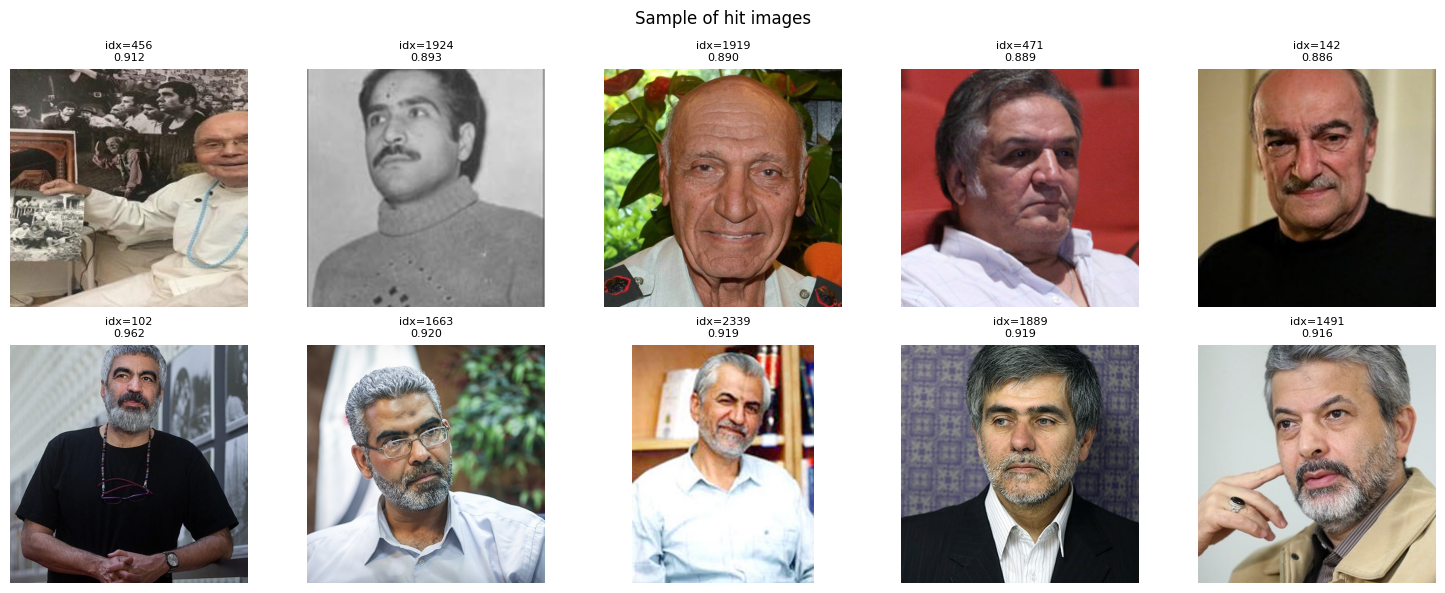

In [12]:
import os
import math
from typing import List, Dict, Any
from PIL import Image
import matplotlib.pyplot as plt

def _first_img_from_row(row) -> str:
    lst = row.get("image_paths_abs", [])
    if isinstance(lst, list):
        for p in lst:
            if isinstance(p, str) and os.path.isfile(p):
                return p
    return ""

def collect_hit_images(
    df: pd.DataFrame,
    items: List[Dict[str, Any]],
    k: int = 5,
    max_images: int = 10
):
    out = []
    for it in items:
        q   = it["question"]
        img = it.get("image") or it.get("image_path") or None

        hits = search_auto(q, image_path=img, k=k, alpha_q=CFG.alpha_q, use_aug=False, n_aug=6)

        for idx, score in hits:
            if not (0 <= idx < len(df)):
                continue
            row = df.iloc[idx]
            p = _first_img_from_row(row)
            if p:
                out.append({
                    "img_path": p,
                    "row_idx": int(idx),
                    "score": float(score),
                    "question": q
                })
                if len(out) >= max_images:
                    return out
    return out

def print_hit_image_paths(hit_list: List[Dict[str, Any]]):
    for i, d in enumerate(hit_list, 1):
        print(f"[{i}] idx={d['row_idx']}  score={d['score']:.4f}  path={d['img_path']}")

def show_hit_images_grid(hit_list: List[Dict[str, Any]], cols: int = 5, title: str = "Top hit images"):
    if not hit_list:
        print("No images to show.")
        return
    n = len(hit_list)
    rows = math.ceil(n / cols)
    plt.figure(figsize=(3*cols, 3*rows))
    for i, d in enumerate(hit_list, 1):
        try:
            img = Image.open(d["img_path"]).convert("RGB")
        except Exception:
            continue
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        cap = f"idx={d['row_idx']}\n{d['score']:.3f}"
        plt.title(cap, fontsize=8)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

hit_list = collect_hit_images(df, image_questions, k=5, max_images=10)
print_hit_image_paths(hit_list)
show_hit_images_grid(hit_list, cols=5, title="Sample of hit images")


In [ ]:
summary[['K','Count','Accuracy@1','Hit@K']].to_csv("image.csv")

In [13]:
import os,math,json,gc
import numpy as np
import pandas as pd
from typing import List,Dict,Any
import torch
from transformers import AutoTokenizer,AutoModelForCausalLM

In [14]:
class GenCFG:
    MODEL_ID = "Qwen/Qwen2-7B-Instruct"
    USE_BF16 = True
    TEMPERATURE = 0.5
    TOP_P = 0.9
    TOP_K = 50
    DO_SAMPLE = True

    TOPK_RETRIEVE = 5
    MAX_CONTEXT_CHARS = 5000
    LANGUAGE_HINT = "fa"

    SYSTEM_PROMPT_FA = (
        "تو یک دستیار پاسخ‌گو هستی که فقط بر اساس متن‌های داده‌شده پاسخ می‌دهی. "
        "اگر پاسخ در متن‌ها نبود، صادقانه بگو «در متن‌های بازیابی‌شده پاسخی پیدا نشد.»"
    )
    SYSTEM_PROMPT_EN = (
        "You are a helpful assistant. Answer only using the retrieved passages. "
        "If the answer is not present, say: 'No answer found in retrieved passages.'"
    )

In [15]:
CFG_GEN = GenCFG()
device = 'cuda' if torch.cuda.is_available else 'cpu'
dtype = torch.bfloat16 if (CFG_GEN.USE_BF16 and torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
print(f"[LLM] loading {CFG_GEN.MODEL_ID} on {device} with dtype={dtype}")

tokenizer = AutoTokenizer.from_pretrained(CFG_GEN.MODEL_ID, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    CFG_GEN.MODEL_ID,
    torch_dtype=dtype if device == "cuda" else torch.float32,
    device_map="auto" if device == "cuda" else None,
)
model.eval()

[LLM] loading Qwen/Qwen2-7B-Instruct on cuda with dtype=torch.bfloat16


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(152064, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear(in_features=3584, out_features=3584, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((3584,), eps=1e-06)
    (rotary_emb):

In [16]:
CFG.alpha_q

0.7

In [24]:
def _truncate_chars(s: str, limit: int) -> str:
    if limit is None or len(s) <= limit: return s
    return s[:limit] + "…"

def retrieve_context_auto(
    df: pd.DataFrame,
    question: str,
    k: int = None,
    image_path: str = None,
    alpha_q: float = 0.7,
    use_aug: bool = False,
    aug_level: str = "low",
    n_aug: int = 1
) -> Dict[str, Any]:
    if k is None:
        k = CFG_GEN.TOPK_RETRIEVE

    q = normalize_digits_months(question)

    if _is_valid_img(image_path):
        route = "fusion"
        hits = search_fusion(
            q, k=k, image_path=image_path,
            alpha_q=alpha_q, use_aug=use_aug, aug_level=aug_level, n_aug=n_aug
        )
    else:
        route = "text_e5"
        hits = search_text_rag(q, k=k)

    ctxs = []
    for idx, score in hits:
        try:
            row = df.iloc[idx]
        except Exception:
            continue
        ctxs.append({
            "index": int(idx),
            "id": row.get("id", idx),
            "score": float(score),
            "bio": str(row.get("bio", "")),
        })
    return {"route": route, "hits": hits, "contexts": ctxs}

def build_prompt(question: str, contexts: List[Dict[str, Any]]) -> str:
    system_text = CFG_GEN.SYSTEM_PROMPT_FA if CFG_GEN.LANGUAGE_HINT == "fa" else CFG_GEN.SYSTEM_PROMPT_EN

    parts = []
    for i, c in enumerate(contexts, 1):
        bi = c.get("bio", "").strip()
        if not bi:
            continue
        parts.append(f"[{i}] {bi}")
    joined_ctx = "\n\n".join(parts)
    joined_ctx = _truncate_chars(joined_ctx, CFG_GEN.MAX_CONTEXT_CHARS)

    lang_note = " (فارسی)" if CFG_GEN.LANGUAGE_HINT == "fa" else ""
    user = (
        f"سؤال{lang_note}: {question}\n\n"
        f"متون بازیابی‌شده:\n{joined_ctx}\n\n"
        f"لطفاً فقط با اتکا به متون بالا پاسخ بده و در پایان منابع را به شکل [1], [2], ... ارجاع بده."
        if CFG_GEN.LANGUAGE_HINT == "fa" else
        f"Question: {question}\n\n"
        f"Retrieved passages:\n{joined_ctx}\n\n"
        f"Answer only using the passages above and cite sources as [1], [2], ..."
    )

    messages = [
        {"role": "system", "content": system_text},
        {"role": "user", "content": user},
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    return prompt

@torch.inference_mode()
def generate_answer(prompt: str) -> str:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    gen = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=CFG_GEN.DO_SAMPLE,
        temperature=CFG_GEN.TEMPERATURE,
        top_p=CFG_GEN.TOP_P,
        top_k=CFG_GEN.TOP_K,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    out = tokenizer.decode(gen[0], skip_special_tokens=True)
    if out.startswith(prompt):
        out = out[len(prompt):]
    return out.strip()

def answer_questions_with_rag(
    df: pd.DataFrame,
    questions: List[Dict[str, Any]],
    k_retrieve: int = None
) -> pd.DataFrame:
    rows = []
    for qd in questions:
        qtext = qd["question"]
        qimg  = qd.get("image_path", None)
        meta  = qd.get("meta", {})

        ret = retrieve_context_auto(df, qtext, k=k_retrieve or CFG_GEN.TOPK_RETRIEVE, image_path=qimg)
        contexts = ret["contexts"]

        prompt = build_prompt(qtext, contexts)
        answer = generate_answer(prompt)

        rows.append({
            "question": qtext,
            "route": ret["route"],
            "indices": [c["index"] for c in contexts],
            "scores":  [c["score"] for c in contexts],
            "answer":  answer,
            "meta":    meta,
        })

        if device == "cuda":
            torch.cuda.empty_cache()
            gc.collect()

    return pd.DataFrame(rows)


In [37]:
import re, json
from typing import List, Dict, Any

_P2E = str.maketrans("۰۱۲۳۴۵۶۷۸۹٠١٢٣٤٥٦٧٨٩", "01234567890123456789")

def _norm_digits(s: str) -> str:
    return str(s).translate(_P2E)

def build_mcq_prompt_simple(question: str, options: List[str], contexts: List[Dict[str, Any]]) -> str:
    sys_fa = "تو فقط براساس متون داده‌شده پاسخ می‌دهی. دقیقاً و فقط یک JSON برگردان."
    sys_en = "Answer only using the provided passages. Return EXACTLY one JSON."
    system_text = sys_fa if getattr(CFG_GEN, "LANGUAGE_HINT", "fa") == "fa" else sys_en

    parts = []
    for i, c in enumerate(contexts, 1):
        bi = (c.get("bio") or "").strip()
        if bi: parts.append(f"[{i}] {bi}")
    ctx = _truncate_chars("\n\n".join(parts), getattr(CFG_GEN, "MAX_CONTEXT_CHARS", 5000))

    opts = "\n".join([f"{i}) {o}" for i, o in enumerate(options)])
    nmax = len(options) - 1

    if getattr(CFG_GEN, "LANGUAGE_HINT", "fa") == "fa":
        user = (
            f"سؤال: {question}\n\n"
            f"گزینه‌ها:\n{opts}\n\n"
            f"متون بازیابی‌شده:\n{ctx}\n\n"
            f"فقط براساس متون بالا پاسخ بده. اگر جواب صریح نیست، نزدیک‌ترین گزینه را حدس بزن.\n"
            f'خروجی «فقط و فقط» این JSON باشد (بدون هیچ متن اضافه): '
            f'{{"answer_index": X, "reason": "..."}}  که در آن X عددی بین 0 و {nmax} است.'
        )
    else:
        user = (
            f"Question: {question}\n\nOptions:\n{opts}\n\nRetrieved:\n{ctx}\n\n"
            f"Answer strictly from passages; if unknown, GUESS the closest.\n"
            f'Return ONLY this JSON (no extra text): {{"answer_index": X, "reason": "..."}} with X in [0..{nmax}].'
        )

    messages = [{"role": "system", "content": system_text},
                {"role": "user", "content": user}]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

def parse_mcq_json_only(text: str, num_options: int, options: List[str]) -> Dict[str, Any]:
    t = _norm_digits(text)
    blocks = re.findall(r'\{[^{}]*\}', t, flags=re.S)
    blocks = [b for b in blocks if "answer_index" in b]
    for blob in blocks[::-1]:
        try:
            j = json.loads(blob)
            idx = int(_norm_digits(j.get("answer_index", "")))
            reason = str(j.get("reason", "")).strip()
            if 0 <= idx < num_options:
                return {"answer_index": idx, "reason": reason or t.strip()}
        except Exception:
            pass

    low = t.lower()
    for i, o in enumerate(options):
        s = str(o).strip().lower()
        if s and s in low and 0 <= i < num_options:
            return {"answer_index": i, "reason": t.strip()}
        if len(s) >= 6 and s[:20] in low and 0 <= i < num_options:
            return {"answer_index": i, "reason": t.strip()}

    return {"answer_index": None, "reason": t.strip()}

@torch.inference_mode()
def answer_single_mcq_simple(df: pd.DataFrame, item: Dict[str, Any], k_retrieve: int = None) -> Dict[str, Any]:
    qtext   = item["question"]
    options = item["options"]
    img     = item.get("image_path") or item.get("image")
    gold    = item.get("correct_answer")

    ret = retrieve_context_auto(df, qtext, k=k_retrieve or getattr(CFG_GEN, "TOPK_RETRIEVE", 5),
                                image_path=img)
    ctxs = ret["contexts"]

    prompt = build_mcq_prompt_simple(qtext, options, ctxs)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    gen = model.generate(
        **inputs,
        max_new_tokens=getattr(CFG_GEN, "MAX_NEW_TOKENS", 128),
        do_sample=getattr(CFG_GEN, "DO_SAMPLE", True),
        temperature=getattr(CFG_GEN, "TEMPERATURE", 0.5),
        top_p=getattr(CFG_GEN, "TOP_P", 0.9),
        top_k=getattr(CFG_GEN, "TOP_K", 50),
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        use_cache=True,
    )
    out = tokenizer.decode(gen[0], skip_special_tokens=True)
    if out.startswith(prompt):
        out = out[len(prompt):]

    parsed   = parse_mcq_json_only(out, len(options), options)
    pred_idx = parsed["answer_index"]

    if pred_idx is None:
        blob = "\n".join([c.get("bio","") for c in ctxs]).lower()
        counts = [(blob.count(str(o).lower()), i) for i, o in enumerate(options)]
        counts.sort(reverse=True)
        pred_idx = counts[0][1] if counts and counts[0][0] > 0 else 0

    pred_text = options[pred_idx]
    correct   = (pred_idx == gold) if gold is not None else None

    return {
        "id": item.get("id"),
        "question": qtext,
        "options": options,
        "route": ret["route"],
        "indices": [c["index"] for c in ctxs],
        "scores":  [c["score"] for c in ctxs],
        "pred_index": pred_idx,
        "pred_text": pred_text,
        "correct": correct,
        "correct_answer": gold,
        "raw": out.strip(),
    }

def answer_mcq_batch_simple(df: pd.DataFrame, items: List[Dict[str, Any]], k_retrieve: int = None):
    rows = [answer_single_mcq_simple(df, it, k_retrieve) for it in items]
    df_pred = pd.DataFrame(rows)
    if "correct" in df_pred.columns and df_pred["correct"].notna().any():
        acc = float(df_pred["correct"].mean())
    else:
        acc = None
    return df_pred, acc


In [42]:
df_pred, acc = answer_mcq_batch_simple(df, image_questions, k_retrieve=5)
print("Accuracy:", acc)
display(df_pred[["id","route","pred_index","pred_text","correct","correct_answer"]])


Accuracy: 0.875


,id,route,pred_index,pred_text,correct,correct_answer
0,1,fusion,0,سعید آقاخانی - بازیگر، فیلم‌نامه‌نویس و کارگرد...,True,0
1,2,fusion,0,حسین پناهی - درگذشته در سال ۱۳۸۳,True,0
2,3,fusion,0,ملیحه قهرمانی - بازیگر، طراح و معلم,True,0
3,4,fusion,0,اکبر اعتماد - سازمان انرژی اتمی ایران,True,0
4,5,fusion,0,حمیدرضا کاتوزیان - حقوقدان و استاد دانشگاه,True,0
5,6,fusion,1,حمیدرضا کاتوزیان - استاد دانشگاه,False,0
6,7,fusion,0,سعید محمدی - خوانندگی، آهنگسازی، ترانه‌سرایی و...,True,0
7,8,fusion,0,سعید آقاخانی - نقش نورالدین خانزاده در سریال ن...,True,0


In [44]:
df_pred.to_csv("images_output.csv")

In [41]:
image_questions=[
    {
        "id": 1,
        "question": "این شخص کیست و چه فعالیت‌هایی داشته است؟",
        "image_path": "/content/drive/MyDrive/images_clean/images_clean/250px-Media_conference_of_Abajan_at_Fajr_festival-8.png",
        "options": [
            "سعید آقاخانی - بازیگر، فیلم‌نامه‌نویس و کارگردان سریال نون خ",
            "حسین پناهی - بازیگر و کارگردان سریال روزگار قریب",
            "کیومرث صابری - نویسنده و طنزپرداز",
            "محمد شاهیده پور - کارگردان تلویزیون"
        ],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 2,
        "question": "این هنرمند چه کسی است و در چه سالی درگذشت؟",
        "image_path": "/content/drive/MyDrive/images_clean/images_clean/%D9%82%D8%B5%D9%87%E2%80%8C%D9%87%D8%A7%DB%8C_%DA%A9%DB%8C%D8%B4_%28%DA%A9%D8%B4%D8%AA%DB%8C_%DB%8C%D9%88%D9%86%D8%A7%D9.png",
        "options": [
            "حسین پناهی - درگذشته در سال ۱۳۸۳",
            "سعید آقاخانی - در قید حیات",
            "کیومرث صابری - درگذشته در سال ۱۳۸۲",
            "محمد شاهیده پور - در قید حیات"
        ],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 3,
        "question": "این شخصیت با چه نام مستعاری شناخته می‌شد و چه فعالیتی داشت؟",
        "image_path": "/content/drive/MyDrive/images_clean/images_clean/Vida_Ghahremani.png",
        "options": [
            "ملیحه قهرمانی - بازیگر، طراح و معلم",
            "حسین پناهی - شاعر و نویسنده",
            "سعید آقاخانی - کارگردان تلویزیون",
            "محمد شاهیده پور - استاد دانشگاه"
        ],
        "correct_answer": 0,
        "category": "literature"
    },
    {
        "id": 4,
        "question": "این شخصیت علمی کیست و بنیان‌گذار چه چیزی بود؟",
        "image_path": "/content/drive/MyDrive/images_clean/images_clean/Akbar_Etemad.png",
        "options": [
            "اکبر اعتماد - سازمان انرژی اتمی ایران",
            "کیومرث صابری - دریافت جایزه ادبی",
            "سعید آقاخانی - دریافت جایزه بهترین کارگردانی",
            "حسین پناهی - انتشار کتاب علمی"
        ],
        "correct_answer": 0,
        "category": "science"
    },
    {
        "id": 5,
        "question": "این شخص کیست و در چه حوزه‌ای فعالیت داشته است؟",
        "image_path": "/content/drive/MyDrive/images_clean/images_clean/Katozian_at_IWPSA2011.png",
        "options": [
            "حمیدرضا کاتوزیان - حقوقدان و استاد دانشگاه",
            "محمد شاهیده پور - مهندس برق",
            "سید محمد حسینی - سیاستمدار",
            "کیومرث صابری - نویسنده"
        ],
        "correct_answer": 0,
        "category": "science"
    },
    {
        "id": 6,
        "question": "این شخص کیست و چه سمتی داشته است؟",
        "image_path": "/content/drive/MyDrive/images_clean/images_clean/Mohammad_Hosseini.png",
        "options": [
            "سید محمد حسینی - وزیر",
            "حمیدرضا کاتوزیان - استاد دانشگاه",
            "محمد شاهیده پور - رئیس دانشکده",
            "کیومرث صابری - سردبیر"
        ],
        "correct_answer": 0,
        "category": "politics"
    },
    {
        "id": 7,
        "question": "این شخصیت که در سال ۱۳۳۷ در تهران متولد شده کیست و در چه زمینه‌ای فعالیت می‌کند؟",
        "image_path": "/content/drive/MyDrive/images_clean/images_clean/Saeed_Mohammadi_on_BBC_Persian.png",
        "options": [
            "سعید محمدی - خوانندگی، آهنگسازی، ترانه‌سرایی و نوازندگی گیتار",
            "محمداسماعیل کوثری  - سپاه پاسداران انقلاب اسلامی، سیاستمدار و نماینده مجلس",
            "محمد دهقان - حقوقدان و سیاستمدار",
            "محمد شاهیده پور - مهندس برق، نویسنده، ویراستار و عضو فرهنگستان مهندسی "
        ],
        "correct_answer": 0,
        "category": "general"
    },
    {
        "id": 8,
        "question": "این بازیگر، فیلم‌نامه‌نویس و کارگردان ایرانی کیست و چه نقش‌های تلویزیونی معروفی داشته است؟",
        "image_path": "/content/drive/MyDrive/images_clean/images_clean/250px-Media_conference_of_Abajan_at_Fajr_festival-8.png",
        "options": [
            "سعید آقاخانی - نقش نورالدین خانزاده در سریال نون خ",
            "حسین پناهی - نقش در سریال روزگار قریب",
            "کیومرث صابری - نویسنده گل آقا",
            "عزت‌الله مهرآوران - بازیگر تئاتر"
        ],
        "correct_answer": 0,
        "category": "cinema"
    }
]

In [26]:
answers_df = answer_questions_with_rag(df, text_questions[0:2], k_retrieve=5)
display(answers_df.head())

,question,route,indices,scores,answer,meta
0,این شخصیت با چه نام مستعاری شناخته می‌شد و چه ...,fusion,"[102, 1663, 1889, 1853, 2339]","[0.9672731757164001, 0.9175997972488403, 0.914...",system\nتو یک دستیار پاسخ‌گو هستی که فقط بر اس...,{}


In [29]:
print(answers_df['answer'].iloc[0])

system
تو یک دستیار پاسخ‌گو هستی که فقط بر اساس متن‌های داده‌شده پاسخ می‌دهی. اگر پاسخ در متن‌ها نبود، صادقانه بگو «در متن‌های بازیابی‌شده پاسخی پیدا نشد.»
user
سؤال (فارسی): این شخصیت با چه نام مستعاری شناخته می‌شد و چه فعالیتی داشت؟

متون بازیابی‌شده:
[1] سروش صحت در سال 1344 در نایین متولد شد. او از سال 1370 تاکنون در زمینه‌های بازیگر، نویسنده و کارگردان فعالیت داشته است. از جمله آثار او می‌توان به «جنگ 77»، «قطار ابدی»، «داستان یک شهر» و «کارآگاه شمسی و دستیارش مادام» اشاره کرد. او در فیلم‌های «ببخشید شما»، «بازی»، «شمس‌العماره» و «زمین انسان‌ها» نیز نقش داشته است. صحت همچنین در سریال‌های «لیسانسه‌ها»، «کتاب باز» و «قیچی» به ایفای نقش پرداخته است. او در فیلم‌های «پوپک و مش ماشاالله»، «سن پطرزبورگ» و «یک فراری از بگبو» نیز حضور داشته است.
این فرد دارای موهای خاکستری و کوتاه است. او ریش و سبیل پرپشتی دارد که به رنگ خاکستری است. چهره‌اش حالتی آرام و متفکرانه دارد. او عینکی با بند رنگی به گردن آویخته و لباسی تیره به تن دارد. پوست او به نظر می‌رسد که رنگی متوسط دارد و دست‌هایش را جلوی ب

In [ ]:
print(answers_df['answer'].iloc[1])

system
تو یک دستیار پاسخ‌گو هستی که فقط بر اساس متن‌های داده‌شده پاسخ می‌دهی. اگر پاسخ در متن‌ها نبود، صادقانه بگو «در متن‌های بازیابی‌شده پاسخی پیدا نشد.»
user
سؤال (فارسی): چه کسی مخالف مشروطیت بود و به‌عنوان بنیان‌گذار اسلام سیاسی در ایران شناخته می‌شود؟

متون بازیابی‌شده:
[1] موسی حکیمی، مشهور به نظم‌السلطنه و میرپنج موسی خان نظم‌السلطنه حکیمی، در سال ۱۸۶۴ میلادی در تبریز، آذربایجان شرقی متولد شد و در سال ۱۹۴۴ میلادی در تهران، تهران درگذشت. او در دوران مشروطیت به‌عنوان مشروطه‌خواه و مبارز فعالیت داشت و در نهضت مشروطیت نقش ایفا کرد.

[2] فضل‌الله نوری مازندرانی، که با نام مستعار شیخ فضل‌الله نوری نیز شناخته می‌شود، در ۲۷ نوامبر ۱۸۴۳ در لاشک مازندران به دنیا آمد و در ۳۱ ژوئیه ۱۹۰۹ در تهران درگذشت. او روحانی، مجتهد و فقیه بود. دوران قاجار، او مخالف مشروطیت و بنیان‌گذار اسلام سیاسی در ایران بود.مردی مسن با صورت کشیده و استخوانی، بینی بلند و قوی، چشمان نافذ، ابروهای پرپشت و تیره. دارای ریش و سبیل کامل خاکستری و پوستی روشن.

[3] محمد علی منتظری، که در انقلاب اسلامی فعالیت داشت، در سال ۱۳

In [45]:
text_questions = [
    {
        "id": 1,
        "question": "کدام یک از این افراد در دوره قاجار به عنوان موسیقی‌دان و شاعر فعالیت می‌کرد و ساز شهرود را اختراع کرده است؟",
        "options": ["ابوحفص سغدی", "نادر گلچین", "داوود آزاد", "سیما بینا"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 2,
        "question": "کدام شخصیت به عنوان اولین زن گردشگر فضایی و اولین ایرانی‌تبار در فضا شناخته می‌شود؟",
        "options": ["نادیا مفتونی", "انوشه انصاری", "زهرا شجاعی", "انسیه خزعلی"],
        "correct_answer": 1,
        "category": "science"
    },
    {
        "id": 3,
        "question": "کدام یک از این افراد در دوره صفویه به عنوان ریاضی‌دان و ستاره‌شناس فعالیت می‌کرد؟",
        "options": ["نظام الدین عبدالعلی بیرجندی", "اردشیر قوام زاده", "سید حسن امین", "فرزاد ناظم"],
        "correct_answer": 0,
        "category": "science"
    },
    {
        "id": 4,
        "question": "کدام خواننده در سال ۱۳۸۰ تیتراژ سریال 'زیر آسمان شهر' را خوانده است؟",
        "options": ["نادر گلچین", "سیما بینا", "امیر تاجیک", "کاوه آفاق"],
        "correct_answer": 2,
        "category": "music"
    },
    {
        "id": 5,
        "question": "کدام یک از این افراد به عنوان مدیر فنی در شرکت یاهو فعالیت کرده است؟",
        "options": ["فرزاد ناظم", "عیسی کلانتری", "سید مناف هاشمی", "قدرت الله علی‌خانی"],
        "correct_answer": 0,
        "category": "technology"
    },
    {
        "id": 6,
        "question": "کدام شاعر در سال ۹۴۰/۴۱ در بنجرودک درگذشت و آرامگاه او در پنجکنت قرار دارد؟",
        "options": ["رودکی", "سنایی", "ابوحفص سغدی", "غنی کشمیری"],
        "correct_answer": 0,
        "category": "literature"
    },
    {
        "id": 7,
        "question": "کدام یک از این افراد در سال ۱۳۷۶ به دلیل مصاحبه با شبکه‌ای ماهواره‌ای ممنوع الفعالیت شد؟",
        "options": ["احمد نجفی", "داریوش فرهنگ", "رضا بنفشه‌خواه", "عباس جمشیدی‌فر"],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 8,
        "question": "کدام خواننده برای خواندن سرود رسمی تیم ملی فوتبال ایران در جام جهانی ۲۰۰۶ آلمان انتخاب شد؟",
        "options": ["نادر گلچین", "سیما بینا", "امیر تاجیک", "کاوه آفاق"],
        "correct_answer": 2,
        "category": "music"
    },
    {
        "id": 9,
        "question": "کدام یک از این افراد در سال ۱۳۵۰ خورشیدی در تشکیل هسته‌های حزب‌الله لبنان نقش داشت؟",
        "options": ["محمّدصالح کمیلی خراسانی", "عیسی کلانتری", "سید مناف هاشمی", "قدرت الله علی‌خانی"],
        "correct_answer": 0,
        "category": "politics"
    },
    {
        "id": 10,
        "question": "کدام یک از این افراد در دانشگاه ییل به عنوان پژوهشگر ارشد در دانشکده حقوق فعالیت داشته است؟",
        "options": ["نادیا مفتونی", "زهرا شجاعی", "انسیه خزعلی", "سید حسن امین"],
        "correct_answer": 0,
        "category": "academic"
    },
    {
        "id": 11,
        "question": "کدام شخصیت به کشف جهش جدید در سرطان پستان و تخمدان و جایزه دستیار تدریس، بورس تحصیلی فرانسه را به دست آورده‌است ؟",
        "options": ["رکسانا مصلحی انگلیسی", "سید حسن امین", "عیسی کلانتری", "محمّدصالح کمیلی خراسانی"],
        "correct_answer": 0,
        "category": "medical"
    },
    {
        "id": 12,
        "question": "کدام یک از این افراد کتاب 'طباخی گیلان' را در سال ۱۳۳۸ منتشر کرده است؟",
        "options": ["فهیمه اکبر", "سیما بینا", "پروین غفاری", "شهره آغداشلو"],
        "correct_answer": 0,
        "category": "literature"
    },
    {
        "id": 13,
        "question": "کدام شاعر  حدیقةالحقیقه، طریق‌التحقیق، سیرالعباد الی المعاد را سروده است؟",
        "options": ["الهامی کرمانشاهی", "رودکی", "سنایی", "ژاله قائم مقامی"],
        "correct_answer": 2,
        "category": "literature"
    },
    {
        "id": 14,
        "question": "کدام یک از این افراد در سال ۱۳۹۴، مرکز سرطان مهر رضوی و در سال ۱۳۹۵، دپارتمان علوم اعصاب در دانشکده پزشکی مشهد را تاسیس کرده‌اند؟",
        "options": ["علی گرجی", "عیسی کلانتری", "سید مناف هاشمی", "محمّدصالح کمیلی خراسانی"],
        "correct_answer": 0,
        "category": "medical"
    },
    {
        "id": 15,
        "question": "کدام هنرمند در سریال '۲۴' در سال ۱۳۸۴ حضور داشته است؟",
        "options": ["شهره آغداشلو", "رضا بنفشه‌خواه", "عباس جمشیدی‌فر", "ویدا جوان"],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 16,
        "question": "کدام یک از این افراد در دوره وزارتش بر کشاورزی (۱۳۶۷-۱۳۷۸) خدمت کرده است؟",
        "options": ["عیسی کلانتری", "سید مناف هاشمی", "قدرت الله علی‌خانی", "اسماعیل جبارزاده"],
        "correct_answer": 0,
        "category": "politics"
    },
    {
        "id": 17,
        "question": "کدام خواننده آلبوم 'یوسف گم‌گشته' را در کارنامه هنری خود دارد؟",
        "options": ["نادر گلچین", "سیما بینا", "امیر تاجیک", "حمیرا"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 18,
        "question": "کدام یک از این افراد در سال ۱۳۹۰ به عضویت شورای عالی سینما درآمد؟",
        "options": ["احمد نجفی", "داریوش فرهنگ", "رضا بنفشه‌خواه", "عباس جمشیدی‌فر"],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 19,
        "question": "کدام شخصیت در سال ۱۳۹۲ نامزد انتخابات شورای شهر تهران شد اما موفق به کسب آرا نشد؟",
        "options": ["احمد نجفی", "عیسی کلانتری", "حبیب‌الله کاسه‌ساز", "سید مناف هاشمی"],
        "correct_answer": 0,
        "category": "politics"
    },
    {
        "id": 20,
        "question": "کدام یک از این افراد رئیس سازمان نظام پزشکی، رئیس کمیته بهداشت مجلس هشتم بوده‌است؟",
        "options": ["سید شهاب‌الدین صدر", "سید حسن امین", "عیسی کلانتری", "محمّدصالح کمیلی خراسانی"],
        "correct_answer": 0,
        "category": "medical"
    },
    {
        "id": 21,
        "question": "کدام یک از این افراد در دانشگاه ییل به عنوان پژوهشگر ارشد در دانشکده حقوق فعالیت داشته است؟",
        "options": ["مریم میرزاخانی", "نادیا مفتونی", "زهرا شجاعی", "انسیه خزعلی"],
        "correct_answer": 1,
        "category": "science"
    },
    {
        "id": 22,
        "question": "کدام خواننده آلبوم 'استرس' را با گروه 'د ویز' در سال ۱۳۸۸ منتشر کرد؟",
        "options": ["کاوه آفاق", "امیر تاجیک", "نادر گلچین", "سیما بینا"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 23,
        "question": "کدام یک از این افراد در سال ۱۳۷۰ کتاب 'ساختار و تاویل متن' را منتشر کرد؟",
        "options": ["بابک احمدی زاده", "سید حسن امین", "نادیا مفتونی", "زهرا شجاعی"],
        "correct_answer": 0,
        "category": "literature"
    },
    {
        "id": 24,
        "question": "کدام شخصیت در دانشگاه کمبریج، آکسفورد و لندن کنسرت برگزار کرده است؟",
        "options": ["داوود آزاد", "سیما بینا", "نادر گلچین", "امیر تاجیک"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 25,
        "question": "کدام یک از این افراد سیاستمدار و هیئت علمی، در سال ۱۳۴۲ در قم متولد شده‌است؟",
        "options": ["مریم میرزاخانی", "نادیا مفتونی", "زهرا شجاعی", "انسیه خزعلی"],
        "correct_answer": 3,
        "category": "science"
    },
    {
        "id": 26,
        "question": "کدام یک از این افراد نویسنده و استاد زبان و ادبیات فارسی، در ۳ تیر ۱۳۳۵ در تهران متولد شده‌است؟",
        "options": ["مریم میرزاخانی", "نادیا مفتونی", "زهرا شجاعی", "انسیه خزعلی"],
        "correct_answer": 2,
        "category": "science"
    },
    {
        "id": 27,
        "question": "کدام خواننده آلبوم 'موسیقی جنوب خراسان' را در کارنامه هنری خود دارد؟",
        "options": ["سیما بینا", "نادر گلچین", "امیر تاجیک", "حمیرا"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 28,
        "question": "کدام یک از این افراد در سال ۱۳۹۶ بر اثر سرطان معده درگذشت؟",
        "options": ["حبیب‌الله کاسه‌ساز", "نادر گلچین", "فریدون فرخزاد", "عزت‌الله مهرآوران"],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 29,
        "question": "کدام شخصیت در سال ۱۳۹۲ تا ۱۴۰۱ دبیر ستاد احیای دریاچه ارومیه بود؟",
        "options": ["عیسی کلانتری", "سید مناف هاشمی", "اسماعیل جبارزاده", "قدرت الله علی‌خانی"],
        "correct_answer": 0,
        "category": "politics"
    },
    {
        "id": 30,
        "question": "کدام یک از این افراد رئیس فرهنگستان علوم پزشکی و رئیس تیم پزشکی علی خامنه‌ای بوده‌اند؟",
        "options": ["سید علیرضا مرندی", "عیسی کلانتری", "سید حسن امین", "محمّدصالح کمیلی خراسانی"],
        "correct_answer": 0,
        "category": "medical"
    },
    {
        "id": 31,
        "question": "کدام هنرمند در فیلم 'خانه‌ای از شن و مه' در سال ۱۳۸۲ بازی کرده است؟",
        "options": ["شهره آغداشلو", "ویدا جوان", "پروین غفاری", "رضا بنفشه‌خواه"],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 32,
        "question": "کدام یک از این افراد در سال ۱۳۶۱ تا ۱۳۶۵ در شرکت مهندسی مشاور یکم ایران فعالیت داشت؟",
        "options": ["سید مجید حسنیزاده", "فرزاد ناظم", "عیسی کلانتری", "اردشیر قوام زاده"],
        "correct_answer": 0,
        "category": "engineering"
    },
    {
        "id": 33,
        "question": "کدام شاعر در حوالی ۸۵۸ در روستای رودک در خراسان به دنیا آمد؟",
        "options": ["محمدطاهر غنی آشای", "رودکی", "سنایی", "الهامی کرمانشاهی"],
        "correct_answer": 1,
        "category": "literature"
    },
    {
        "id": 34,
        "question": "کدام یک از این افراد در سال ۱۳۶۵ تا ۱۳۷۴ در شرکت اوراکل فعالیت می‌کرد؟",
        "options": ["فرزاد ناظم", "سید مجید حسنیزاده", "عیسی کلانتری", "اردشیر قوام زاده"],
        "correct_answer": 0,
        "category": "technology"
    },
    {
        "id": 35,
        "question": "کدام خواننده آلبوم 'با قرص‌ها می‌رقصد' را در سال ۱۳۹۴ منتشر کرد؟",
        "options": ["کاوه آفاق", "امیر تاجیک", "نادر گلچین", "سیما بینا"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 36,
        "question": "کدام یک از این افراد در سال ۱۴۰۰ بر اثر کرونا درگذشت؟",
        "options": ["عزت‌الله مهرآوران", "حبیب‌الله کاسه‌ساز", "نادر گلچین", "فریدون فرخزاد"],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 37,
        "question": "کدام شخصیت برنده مدال آژانس بین‌المللی سرطان، رتبه اول محقق گروه علوم بالینی است؟",
        "options": ["رضا ملک‌زاده", "عیسی کلانتری", "سید حسن امین", "محمّدصالح کمیلی خراسانی"],
        "correct_answer": 0,
        "category": "medical"
    },
    {
        "id": 38,
        "question": "کدام یک از این افراد در بازی ویدئویی 'تأثیر فراگیر ۲' در سال ۱۳۸۹ حضور داشت؟",
        "options": ["شهره آغداشلو", "ویدا جوان", "رضا بنفشه‌خواه", "عباس جمشیدی‌فر"],
        "correct_answer": 0,
        "category": "entertainment"
    },
    {
        "id": 39,
        "question": "کدام شاعر در سال ۴۷۳ هجری قمری در غزنی افغانستان به دنیا آمد؟",
        "options": ["سنایی", "رودکی", "محمدطاهر غنی آشای", "الهامی کرمانشاهی"],
        "correct_answer": 0,
        "category": "literature"
    },
    {
        "id": 40,
        "question": "کدام یک از این افراد در سال ۱۳۹۲ برنامه 'حرفی برای گفتن' را ساخت؟",
        "options": ["فریدون فرح‌اندوز", "عزت‌الله مهرآوران", "رضا بنفشه‌خواه", "عباس جمشیدی‌فر"],
        "correct_answer": 0,
        "category": "media"
    },
    {
        "id": 41,
        "question": "کدام خواننده در سال ۱۳۶۹ آلبوم 'الله اکبر' را منتشر کرد؟",
        "options": ["حمیرا", "سیما بینا", "نادر گلچین", "امیر تاجیک"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 42,
        "question": "کدام یک از این افراد در سال ۱۳۴۰ به ایلام مهاجرت کرد؟",
        "options": ["سید مجید حسنیزاده", "عیسی کلانتری", "فرزاد ناظم", "اردشیر قوام زاده"],
        "correct_answer": 0,
        "category": "academic"
    },
    {
        "id": 43,
        "question": "کدام شخصیت در سال ۱۳۸۸ در واشینگتن، دی.سی. درگذشت؟",
        "options": ["فهیمه اکبر", "شهره آغداشلو", "پروین غفاری", "سیما بینا"],
        "correct_answer": 0,
        "category": "culture"
    },
    {
        "id": 44,
        "question": "کدام یک از این افراد در سال ۱۳۹۶ آهنگ 'شادی زندگی تویی' را منتشر کرد؟",
        "options": ["حمیرا", "سیما بینا", "نادر گلچین", "امیر تاجیک"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 45,
        "question": "کدام هنرمند با نام مستعار 'غول برره' شناخته می‌شود؟",
        "options": ["احمد ایراندوست", "رضا بنفشه‌خواه", "عباس جمشیدی‌فر", "عزت‌الله مهرآوران"],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 46,
        "question": "کدام یک از این افراد در سال ۱۳۹۵ در تهران درگذشت؟",
        "options": ["افشین یداللهی", "نادر گلچین", "فریدون فرخزاد", "عزت‌الله مهرآوران"],
        "correct_answer": 0,
        "category": "literature"
    },
    {
        "id": 47,
        "question": "کدام شخصیت در سال ۱۳۶۲ آلبوم 'آستان جانان' محمدرضا شجریان را تنظیم کرد؟",
        "options": ["سیما بینا", "نادر گلچین", "داوود آزاد", "امیر تاجیک"],
        "correct_answer": 0,
        "category": "music"
    },
    {
        "id": 48,
        "question": "کدام یک از این افراد در سال ۱۳۵۱ در فیلم 'بهار پشت پنجره' بازی کرد؟",
        "options": ["شهره آغداشلو", "پروین غفاری", "ویدا جوان", "رضا بنفشه‌خواه"],
        "correct_answer": 0,
        "category": "cinema"
    },
    {
        "id": 49,
        "question": "کدام شاعر در اسفند ۱۲۶۲ در فراهان همدان به دنیا آمد؟",
        "options": ["ژاله قائم مقامی", "الهامی کرمانشاهی", "منوچهر آتشی", "افشین یداللهی"],
        "correct_answer": 0,
        "category": "literature"
    },
    {
        "id": 50,
        "question": "کدام یک از این افراد در سال ۱۳۷۱ در بن، آلمان درگذشت؟",
        "options": ["فریدون فرخزاد", "نادر گلچین", "فهیمه اکبر", "عزت‌الله مهرآوران"],
        "correct_answer": 0,
        "category": "arts"
    }
]


In [47]:
df_pred, acc = answer_mcq_batch_simple(df, text_questions, k_retrieve=5)
print("Accuracy:", acc)
display(df_pred[["id","route","pred_index","pred_text","correct","correct_answer"]])

Accuracy: 0.54


,id,route,pred_index,pred_text,correct,correct_answer
0,1,text_e5,0,ابوحفص سغدی,True,0
1,2,text_e5,1,انوشه انصاری,True,1
2,3,text_e5,0,نظام الدین عبدالعلی بیرجندی,True,0
3,4,text_e5,2,امیر تاجیک,True,2
4,5,text_e5,0,فرزاد ناظم,True,0
5,6,text_e5,3,غنی کشمیری,False,0
6,7,text_e5,2,رضا بنفشه‌خواه,False,0
7,8,text_e5,2,امیر تاجیک,True,2
8,9,text_e5,0,محمّدصالح کمیلی خراسانی,True,0
9,10,text_e5,2,انسیه خزعلی,False,0
